<a name="top"></a>
<img src="https://netacad.centralesupelec.fr/img/cs.jpg" width="200" style="display:inline;">
<img src="static/Blanc.png" width="50%" style="display:inline;">
<img src="static/Airbnb_Logo.png" width="200" style="display:inline;">

<h1>
<center>Airbnb price prediction</center>
</h1>

---


<center>
<nav>
<a href="https://github.com/flaviendeseure/Airbnb_berlin_price_prediction">Github</a> |
<a href="https://centralesupelec.edunao.com/course/view.php?id=5285">CentraleSupélec</a>
</nav>
</center>

## About the project
---
This project aims to predict the price of a night's accommodation offered on the short-term rental website Airbnb in the city of Berlin.

## *Table of Contents*
- [Utils](#utils)
    - [Imports](#imports)
    - [Helper Functions](#helper_functions)
- [Exploratory Data Analysis](#eda)
    - [Global analysis](#general_analysis)
    - [Feature analysis](#analysis_per_col)
    - [Target analysis](#target_analysis)
    - [PCA](#pca)
    - [Conclusion analysis](#conclusion)
- [Preprocessing](#preprocessing)
    - [Feature selection](#feat_selec)
    - [Missing values](#missing_values)
    - [Split](#split)
    - [Categorical features](#cat_feat)
    - [Scaling](#scaling)
    - [Feature engineering](#feature_eng)
    - [Split analysis](#split_ana)
    - [PCA](#pca_prep)
    - [Definitive Dataset](#def_dataset)
    
- [Modeling](#modeling)
    - [Linear Regression](#linear)
    - [Stochastic Gradient Descent](#sgd)
    - [ElasticNet](#elast)
    - [Bayesian Ridge](#bay_ridge)
    - [Gradient Boosting](#gb)
    - [Random Forest](#rf)
    - [Support Vector Machine](#rf)
- [Best model](#best_model)

<a name="utils">

## Utils
---

<a name="imports">

### Imports

In [1]:
# Utils
## System
import os
import warnings
import time
import math
from datetime import datetime

# Data
import pandas as pd
import numpy as np

# Exploratory analysis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## PCA
from sklearn.decomposition import PCA
from bioinfokit.visuz import cluster

# Preprocessing
## Split data
from sklearn.model_selection import train_test_split
## Missing values
from sklearn.impute import SimpleImputer
## Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale
## Outliers
from scipy.stats import iqr
## Categorical features
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Modeling
## Sklearn models
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor 
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
## XGboost models
from xgboost.sklearn import XGBRegressor
## Lightgbm models
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
## Tuning hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
## Stepwise selection
import statsmodels.api as sm
import itertools
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Metrics
from sklearn.metrics import explained_variance_score, r2_score , mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

In [2]:
# Options
pd.set_option('display.max_columns', 40)
warnings.filterwarnings("ignore")
plt.style.use('seaborn-poster')
sns.set_theme(style="white")

<a href="#top">back to top</a>

<a name="helper_functions">

### Helper Functions

#### Exploratory analysis

In [3]:
def missing_values_rate_display(feature_name, dataset):
    missing_values_count = dataset[feature_name].isna().sum()
    missing_value_rate = missing_values_count/dataset.shape[0]
    star_count = dataset[feature_name][dataset[feature_name]=="*"].count()
    star_rate = star_count/dataset.shape[0]
    print(f"Missing value for {feature_name} columns: {100*missing_value_rate:.3f}% ({missing_values_count}/{dataset.shape[0]})",
          f"Star value for {feature_name} columns: {100*star_rate:.3f}% ({star_count}/{dataset.shape[0]})",
          sep="\n")
    
def describe_feature(feature_name, feature_values, dataset, bar_or_hist='bar', mean_or_median='mean', display_hist=True):
    agg_list = ['min', 'max', 'mean', 'count', 'median']
    group_by = dataset.groupby([feature_name])["Price"].agg(agg_list).reindex(feature_values)
    min_price_per_feature = group_by["min"].values
    max_price_per_feature = group_by["max"].values
    mean_med_price_per_feature = group_by["mean"].values if mean_or_median=="mean" else group_by["median"].values
    count_price_per_feature = group_by["count"].values
    
    # Histogram
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    
    ax[0].bar(feature_values, count_price_per_feature)
    ax[0].set_title(f"{feature_name} histogram")

    # Histogram per price
    ax[1].bar(feature_values, mean_med_price_per_feature, label = f"{mean_or_median} price")
    ax[1].set_yscale('log')
    
    ax2 = ax[1].twinx()
    ax2.plot(feature_values, min_price_per_feature, label="min price", color="green")
    ax2.plot(feature_values, max_price_per_feature, label="max price", color="red")
    ax2.set_yscale('log')
    
    if display_hist:
        ax3 = ax[1].twinx()
        ax3.bar(feature_values, count_price_per_feature, label="histogram", alpha=.2)

    ax[1].legend()
    ax[1].set_title(f"Histogram of the {mean_or_median} price of a rental according to {feature_name} values")
    
    fig.suptitle(feature_name)
    plt.show()
    
def display_corr_matrix(corr_mat):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

#### Preprocessing

In [291]:
def test_distribution(df1, df2, test_method, test_descrp, col=None, alpha=0.05):
    if col != None:
        p_value = test_method(df1[col], df2[col]).pvalue
    else:
        p_value = test_method(df1[col], df2[col]).pvalue
    print(test_descrp)
    if p_value > alpha:
        print(f"Same distribution: pvalue>alpha ({round(p_value,4)}>{alpha}) so we cannot reject the null hypothesis")
    else:
        print(f"Different distributions: pvalue<alpha ({round(p_value,4)}<{alpha}) so we reject the null hypothesis")    

def compare_discrete_distribution(dataset, col, dataset_test=None, alpha=0.05):   
    (df1, df2) = dataset
    if dataset_test == None:
        (df1_test, df2_test) = dataset
    else:
        (df1_test, df2_test) = dataset_test
    test_distribution(df1_test, df2_test, stats.ttest_ind, 
                      "Student T-test: test differences in means (global)", 
                      col=col, alpha=alpha)
    
    df_bar1 = pd.DataFrame(df1[col].value_counts(normalize=True)).sort_values(col)
    df_bar2 = pd.DataFrame(df2[col].value_counts(normalize=True)).sort_values(col)

    plt.barh(df_bar1.index, df_bar1[col])
    plt.barh(df_bar2.index, df_bar2[col], alpha=0.5)
    plt.title(f"Comparison of train and test distribution for {col}")
    plt.show()
    
def compare_continuous_distribution(dataset, col=None, dataset_test=None, bins=None, alpha=0.05):
    (df1, df2) = dataset
    if dataset_test == None:
        (df1_test, df2_test) = dataset
    else:
        (df1_test, df2_test) = dataset_test
    if col == None:
        df1 = pd.DataFrame(df1)
        df2 = pd.DataFrame(df2)
        df1_test = pd.DataFrame(df1_test)
        df2_test = pd.DataFrame(df2_test)
        col = "Price"
        
    test_distribution(df1_test, df2_test, stats.ttest_ind, 
                      "Student T-test: test differences in means (global)", 
                      col=col, alpha=alpha)
        
    if bins == None:
        bins = len(df1[col].unique()) if len(df1[col].unique())<20 else 30
    fig, axes = plt.subplots(2,1,figsize=(12,12))
    sns.distplot(df1[col], hist=True, kde=True, 
                 bins=bins, color = 'blue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2, 'color':'green'}, ax=axes[0])
    sns.distplot(df2[col], hist=True, kde=True, 
                 bins=bins, color = 'orange', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2, 'color':'orange'}, ax=axes[0])
    axes[0].set_title(f"Comparison of train and test distribution for {col}")
    
    df_pct['train'] = np.percentile(df1_test[col], range(100)) 
    df_pct['test'] = np.percentile(df2_test[col], range(100))
    axes[1].scatter(x='train', y='test', data=df_pct, label='Actual fit');
    sns.lineplot(x='train', y='train', data=df_pct, color='r', label='Line of perfect fit', ax=axes[1]);
    axes[1].set_xlabel(f'Quantile of {col}, train group')
    axes[1].set_ylabel(f'Quantile of {col}, test group')
    axes[1].legend()
    axes[1].set_title("QQ plot")
    fig.suptitle(f"Analysis of {col}")
    plt.show()

#### Modeling

In [5]:
def processSubset(feature_set):
    # Fit OLS (Ordinary Least Squares) model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train_encoded1[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_train_encoded[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def forward(features):
    # Pull out features we still need to process
    remaining_features = [d for d in X_train_encoded1.columns if d not in features]
    
    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward(features):
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

#### Scoring

In [6]:
def score_model(model, X_test, y_test, cross_valid=False, cv=10):
    y_preds = model.predict(X_test)
    mse = mean_squared_error(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    r2 = r2_score(y_test, y_preds)
    adj_r2 = 1 - (1-r2_score(y_test, y_preds)) * (len(y)-1)/(len(y)-X.shape[1]-1)
    print(f"{model.__str__()[:-2]}",
          f"mse = {mse:.2f}",
          f"mae = {mae:.2f}",
          f"r2 = {r2:.3f}",
          f"adjusted r2 = {adj_r2:.3f}",
          sep="\n")
        
    if cross_valid:
        cross_val = cross_validate(model, X_test, y_test, cv=cv, 
                                   scoring=["neg_mean_squared_error",
                                            "r2",
                                            "neg_mean_absolute_error"],
                                   return_train_score=True)
        mse_test = [-cross_val["test_neg_mean_squared_error"].mean(),
                    np.sqrt(cross_val["test_neg_mean_squared_error"].var())]
        mse_train = [-cross_val["train_neg_mean_squared_error"].mean(),
                    np.sqrt(cross_val["train_neg_mean_squared_error"].var())]
        mae_test = [-cross_val["test_neg_mean_absolute_error"].mean(),
                    np.sqrt(cross_val["test_neg_mean_absolute_error"].var())]
        mae_train = [-cross_val["train_neg_mean_absolute_error"].mean(),
                    np.sqrt(cross_val["train_neg_mean_absolute_error"].var())]
        r2_test = [cross_val["test_r2"].mean(), np.sqrt(cross_val["test_r2"].var())]
        r2_train = [cross_val["train_r2"].mean(), np.sqrt(cross_val["train_r2"].var())]
        adj_r2_list_test = np.apply_along_axis(lambda r2:  1 - (1-r2) * ((len(y_test)/cv)-1)/((len(y_test)/cv)-X_test.shape[1]-1),
                                     0,cross_val["test_r2"])
        adj_r2_list_train = np.apply_along_axis(lambda r2:  1 - (1-r2) * ((len(y_test)/cv)-1)/((len(y_test)/cv)-X_test.shape[1]-1),
                                     0,cross_val["test_r2"])
        adj_r2_test = [adj_r2_list_test.mean(), np.sqrt(adj_r2_list_test.var())]
        adj_r2_train = [adj_r2_list_train.mean(), np.sqrt(adj_r2_list_train.var())]
        
        print(f"\nCross_validation ({cv} cv)",
              f"mse = mean:{mse_test[0]:.2f} | std:{mse_test[1]:.2f}",
              f"mae = mean:{mae_test[0]:.2f} | std:{mae_test[1]:.2f}",
              f"r2 = mean:{r2_test[0]:.3f} | std:{r2_test[1]:.3f}",
              f"adjusted r2 = mean:{adj_r2_test[0]:.3f} | std:{adj_r2_test[1]:.3f}",
             sep="\n")
        
        cv_l = range(cv)
        fig, axes = plt.subplots(2,2, figsize=(16,12))
        axes[0,0].plot(cv_l,-cross_val["test_neg_mean_squared_error"], label='mse test', color="green")
        axes[0,0].plot(cv_l,-cross_val["train_neg_mean_squared_error"], label='mse train', color="red")
        axes[0,0].plot(cv_l,[mse_test[0] for i in cv_l],'--', label='mean mse test', color="green")
        axes[0,0].plot(cv_l,[mse_train[0] for i in cv_l],'--', label='mean mse train', color="red")
        axes[0,1].plot(cv_l,-cross_val["test_neg_mean_absolute_error"], label='mae test', color="green")
        axes[0,1].plot(cv_l,-cross_val["train_neg_mean_absolute_error"], label='mae train', color="red")
        axes[0,1].plot(cv_l,[mae_test[0] for i in cv_l],'--', label='mean mae test', color="green")
        axes[0,1].plot(cv_l,[mae_train[0] for i in cv_l],'--', label='mean mae train', color="red")
        
        axes[1,0].plot(cv_l,cross_val["test_r2"], label='r2 test', color="green")
        axes[1,0].plot(cv_l,cross_val["train_r2"], label='r2 train', color="red")
        axes[1,0].plot(cv_l,[r2_test[0] for i in cv_l],'--', label='mean r2 test', color="green")
        axes[1,0].plot(cv_l,[r2_train[0] for i in cv_l],'--', label='mean r2 train', color="red")
        axes[1,1].plot(cv_l,adj_r2_list_test, label='adj r2 test', color="green")
        axes[1,1].plot(cv_l,adj_r2_list_train, label='adj r2 train', color="red")
        axes[1,1].plot(cv_l,[adj_r2_test[0] for i in cv_l],'--', label='mean adj r2 test', color="green")
        axes[1,1].plot(cv_l,[adj_r2_train[0] for i in cv_l],'--', label='mean adj r2 train', color="red")
        axes[0,0].legend()
        axes[0,1].legend()
        axes[1,0].legend()
        axes[1,1].legend()

<a href="#top">back to top</a>

<a name="importdata">

## Exploratory Data Analysis
---

<a name="importdata">
    
### Import data

In [7]:
DATA_DIR = "data"
DATA_FILE = "train_airbnb_berlin.csv"
PATH_DATA = os.path.join(DATA_DIR, DATA_FILE)
dataset = pd.read_csv(PATH_DATA)
dataset.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Square Feet,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10437.0,DE,Germany,52.54652,13.41792,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,2,6,2017-07-07,2017-08-08,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,Berlin,13187.0,DE,Germany,52.56512,13.42214,t,Apartment,Entire home/apt,2,1.0,2.0,2.0,NaN,2,7,6,2015-05-26,2019-04-30,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10439.0,DE,Germany,52.54741,13.42521,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,NaN,1,1,2,2016-04-19,2016-07-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10245,DE,Germany,52.50958,13.45144,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,2,4,2018-07-31,2018-08-12,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,Berlin,10405.0,DE,Germany,52.52995,13.41558,t,Apartment,Private room,3,1.0,1.0,2.0,NaN,1,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


<a href="#top">back to top</a>

<a name="general_analysis">
    
### Global analysis

##### Dataset Description

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15692 entries, 0 to 15691
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Listing ID             15691 non-null  float64
 1   Listing Name           15638 non-null  object 
 2   Host ID                15692 non-null  float64
 3   Host Name              15670 non-null  object 
 4   Host Since             15671 non-null  object 
 5   Host Response Time     8617 non-null   object 
 6   Host Response Rate     8617 non-null   object 
 7   Is Superhost           15669 non-null  object 
 8   neighbourhood          15692 non-null  object 
 9   Neighborhood Group     15692 non-null  object 
 10  City                   15691 non-null  object 
 11  Postal Code            15463 non-null  object 
 12  Country Code           15692 non-null  object 
 13  Country                15692 non-null  object 
 14  Latitude               15692 non-null  float64
 15  Lo

In [9]:
dataset.describe()

,Listing ID,Host ID,Latitude,Longitude,Square Feet,Reviews,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price
count,1.569100e+04,1.569200e+04,15692.000000,15692.000000,303.000000,15692.000000,12730.000000,12721.000000,12722.000000,12719.000000,12722.000000,12721.000000,12720.000000,15683.000000
mean,1.780062e+07,6.119042e+07,52.509893,13.407334,445.900990,19.452014,94.717282,9.717475,9.328407,9.769164,9.779201,9.556874,9.458097,60.342983
std,9.952544e+06,6.739421e+07,0.031286,0.058646,414.817342,39.483853,7.069787,0.671793,1.023807,0.620347,0.619545,0.731109,0.788891,48.829687
min,2.241500e+04,1.101500e+04,52.369270,13.121400,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000
25%,9.052831e+06,9.274528e+06,52.488920,13.376025,0.000000,1.000000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,32.000000
50%,1.865037e+07,3.358182e+07,52.509100,13.417250,440.000000,5.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,49.000000
75%,2.611308e+07,9.325677e+07,52.532713,13.439750,700.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,70.000000
max,3.467450e+07,2.609698e+08,52.639670,13.709020,1912.000000,424.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,900.000000


##### Heatmap - NaN

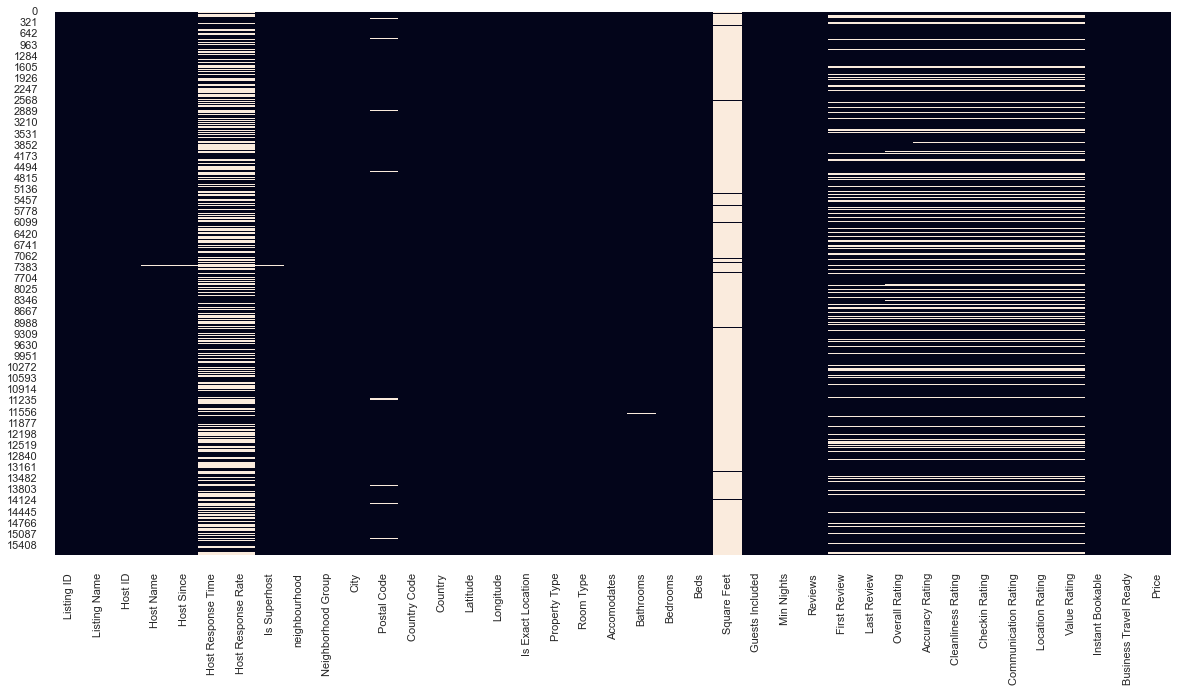

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(dataset.isna(),cbar=False)
plt.show()

**Analysis:**
- There are too many missing values for square feet

##### Heatmap - stars

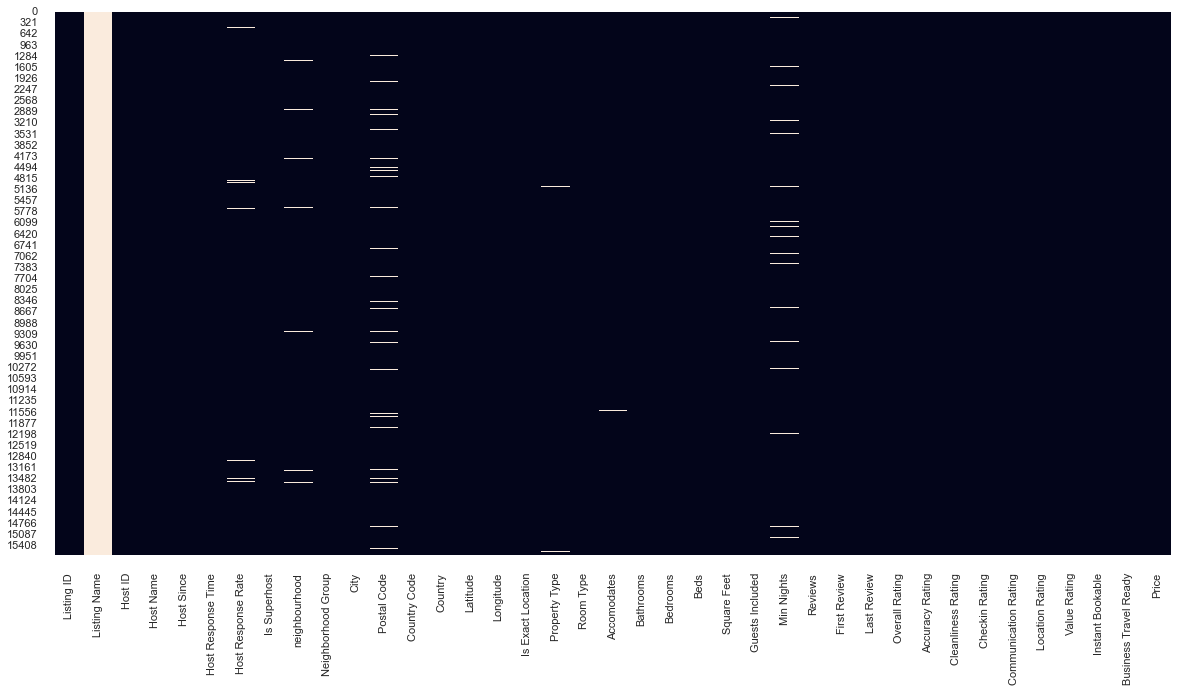

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(dataset=="*",cbar=False)
plt.show()

**Analysis:**
- Stars seems to be some NMAR (simply errors)

##### Heatmap - all missing values

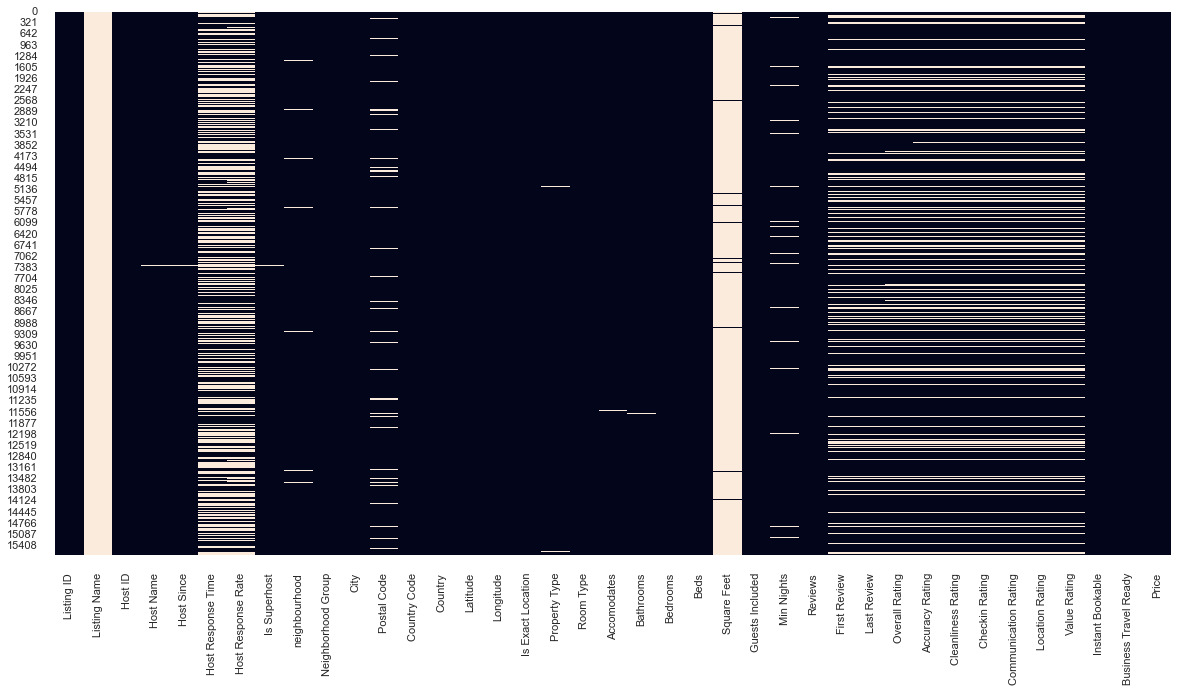

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(dataset.replace("*", np.NaN).isna(),cbar=False)
plt.show()

**Analysis:**
- The `First Review`, `Last Review`, `OverallRating`, `AccuracyRating`, `CleanlinessRating`, `Checkin Rating`, `Communication Rating`, `Location Rating` and `Value Rating` variables have mostly the same missing value. These missing values are MAR (it depends if there are some reviews for the property). This info has been verified below.  
- Same conclusion with the `Host Response Time`, `Host Response Rate` variables

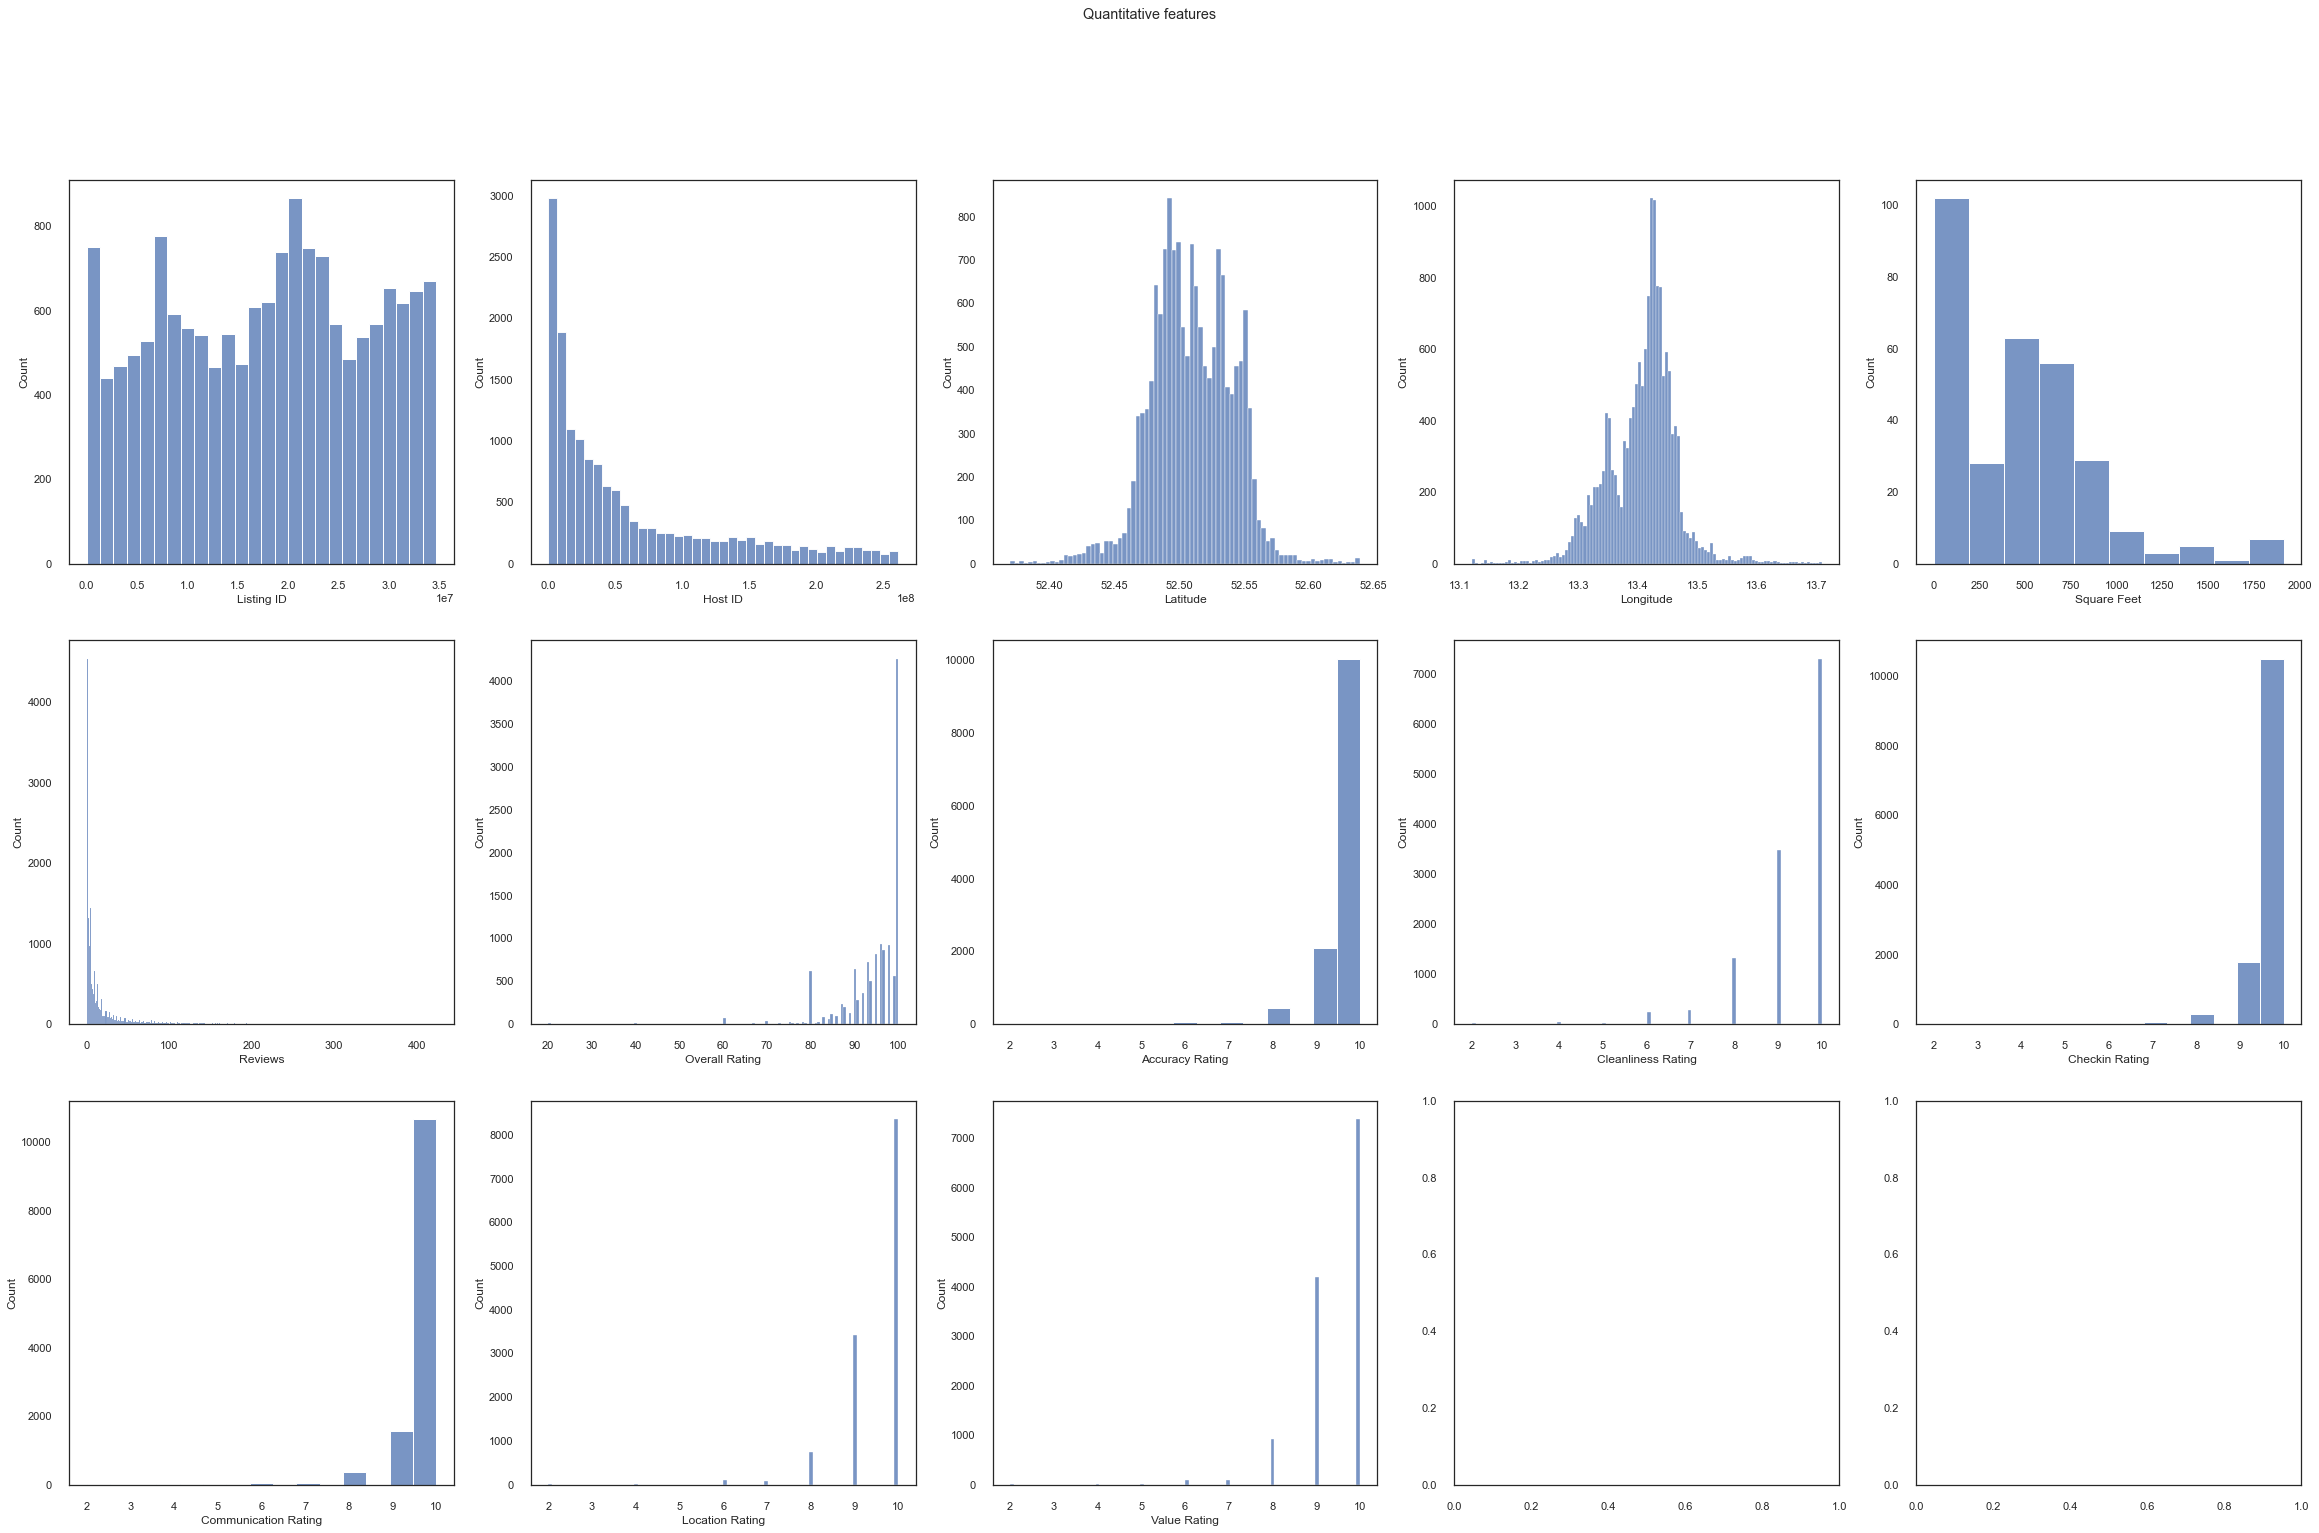

In [13]:
numerical_dataset = dataset.drop(["Price"], axis=1).select_dtypes(exclude=['object'])

fig, axes = plt.subplots(3,5, figsize=(8*5,8*3))
for i,col in enumerate(numerical_dataset):
    sns.histplot(dataset[col], ax=axes[i//5,i%5])
fig.suptitle("Quantitative features")
plt.show()

<a href="#top">back to top</a>

<a name="analysis_per_col">
    
### Feature analysis

In [14]:
dataset_exp = dataset.copy()

In [15]:
## Dataframe used to store new features created
new_features = dataset["Listing ID"]

#### Unusable features

##### Listing ID

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable represents an id, it does not hold any information. Therefore we won't use it.
</div>

<a href="#top">back to top</a>

##### Listing Name

In [16]:
missing_values_rate_display("Listing Name", dataset)

Missing value for Listing Name columns: 0.344% (54/15692)
Star value for Listing Name columns: 99.656% (15638/15692)


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable represents a name, as we don't want to create biases in our model, we won't use it. It has 99% of star values anyway.
</div>

<a href="#top">back to top</a>

##### Host ID

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable also represents an id. We won't use it.
</div>

<a href="#top">back to top</a>

##### Host Name

In [17]:
missing_values_rate_display("Host Name", dataset)

Missing value for Host Name columns: 0.140% (22/15692)
Star value for Host Name columns: 0.000% (0/15692)


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable represents a name, as we don't want to create biases in our model, we won't use it
</div>

<a href="#top">back to top</a>

##### City

In [18]:
missing_values_rate_display("City", dataset)

Missing value for City columns: 0.006% (1/15692)
Star value for City columns: 0.300% (47/15692)


In [19]:
print("Possible values of the 'City' feature:\n",dataset["City"].unique())

Possible values of the 'City' feature:
 ['Berlin' '*' nan]


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

##### Country Code

In [20]:
missing_values_rate_display("Country Code", dataset)

Missing value for Country Code columns: 0.000% (0/15692)
Star value for Country Code columns: 0.000% (0/15692)


In [21]:
print("Possible values of the 'Country Code' feature:\n",dataset["Country Code"].unique())

Possible values of the 'Country Code' feature:
 ['DE']


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

##### Country

In [22]:
missing_values_rate_display("Country", dataset)

Missing value for Country columns: 0.000% (0/15692)
Star value for Country columns: 0.000% (0/15692)


In [23]:
print("Possible values of the 'Country' feature:\n",dataset.Country.unique())

Possible values of the 'Country' feature:
 ['Germany']


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

##### Square Feet

In [24]:
missing_values_rate_display("Square Feet", dataset)

Missing value for Square Feet columns: 98.069% (15389/15692)
Star value for Square Feet columns: 0.000% (0/15692)


<div class="alert alert-block alert-info">
<b>Rq:</b> We could use other features to estimate its value, but it would create dependence between variables</div>

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be use, it contains too much missing values
</div>

##### Business Travel Ready

In [25]:
missing_values_rate_display("Business Travel Ready", dataset)

Missing value for Business Travel Ready columns: 0.000% (0/15692)
Star value for Business Travel Ready columns: 0.000% (0/15692)


In [26]:
dataset["Business Travel Ready"].value_counts()

f    15692
Name: Business Travel Ready, dtype: int64

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value.
</div>

#### Host Since

##### Missing Values

In [27]:
missing_values_rate_display("Host Since", dataset)

Missing value for Host Since columns: 0.134% (21/15692)
Star value for Host Since columns: 0.000% (0/15692)


##### Analysis

In [28]:
dataset_host = dataset_exp[["Host Since", "Price"]].copy()
dataset_host["Host Since date"] = pd.to_datetime(dataset_host["Host Since"])
dataset_host["Host Since date year"] = dataset_host["Host Since date"].dt.year
dataset_host["Host Since date month"] = dataset_host["Host Since date"].dt.month

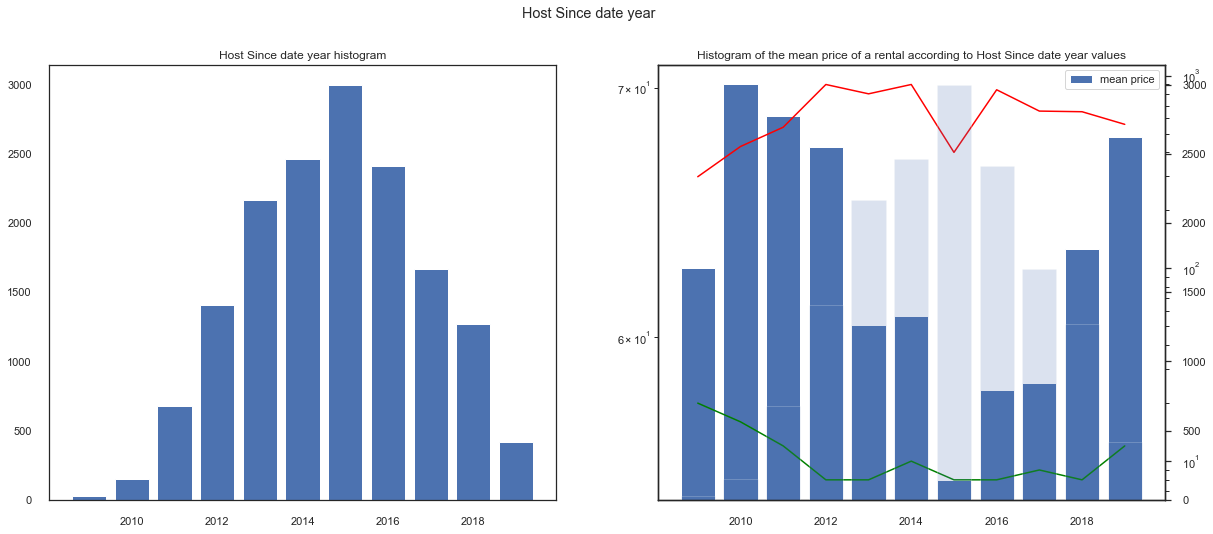

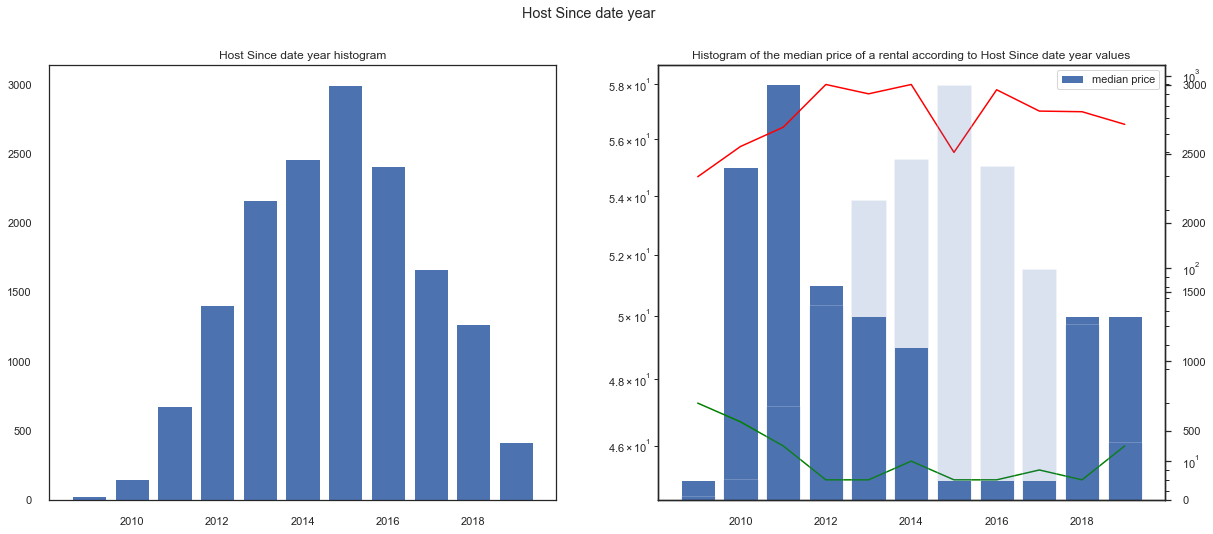

In [29]:
host_since_values = sorted(dataset_host["Host Since date year"].unique())
describe_feature("Host Since date year", host_since_values, dataset_host, mean_or_median='mean')
describe_feature("Host Since date year", host_since_values, dataset_host, mean_or_median='median')

In [30]:
dataset_host.pivot_table(
    index=["Host Since date year"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Host Since date year,,,,
2009.0,20.0,299.0,62.629630,45.0
2010.0,16.0,429.0,70.141892,55.0
2011.0,12.0,540.0,68.786667,58.0
2012.0,8.0,900.0,67.474769,51.0
2013.0,8.0,805.0,60.432918,50.0
2014.0,10.0,900.0,60.773539,49.0
2015.0,8.0,400.0,54.931955,45.0
2016.0,8.0,845.0,58.055004,45.0


##### Correlation

In [31]:
dataset_host.corr()

,Price,Host Since date year,Host Since date month
Price,1.000000,-0.031938,0.003326
Host Since date year,-0.031938,1.000000,-0.168135
Host Since date month,0.003326,-0.168135,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> We could use the year when the host create its account even if the correlations are low.
</div>

<a href="#top">back to top</a>

#### Host Response Time

##### Missing Values

In [32]:
missing_values_rate_display("Host Response Time", dataset)

Missing value for Host Response Time columns: 45.087% (7075/15692)
Star value for Host Response Time columns: 0.000% (0/15692)


##### Analysis

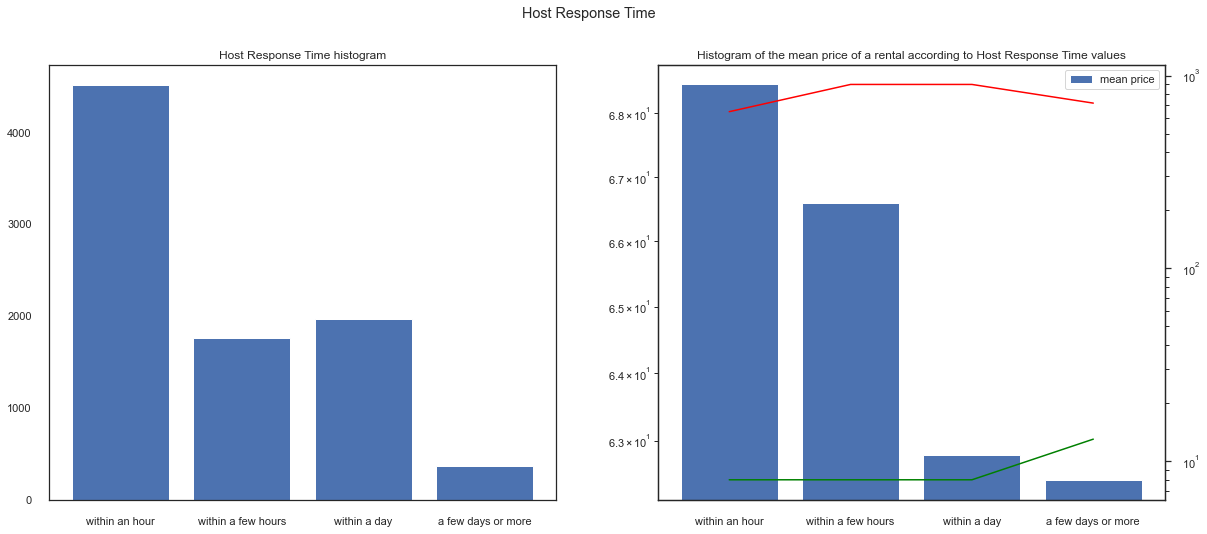

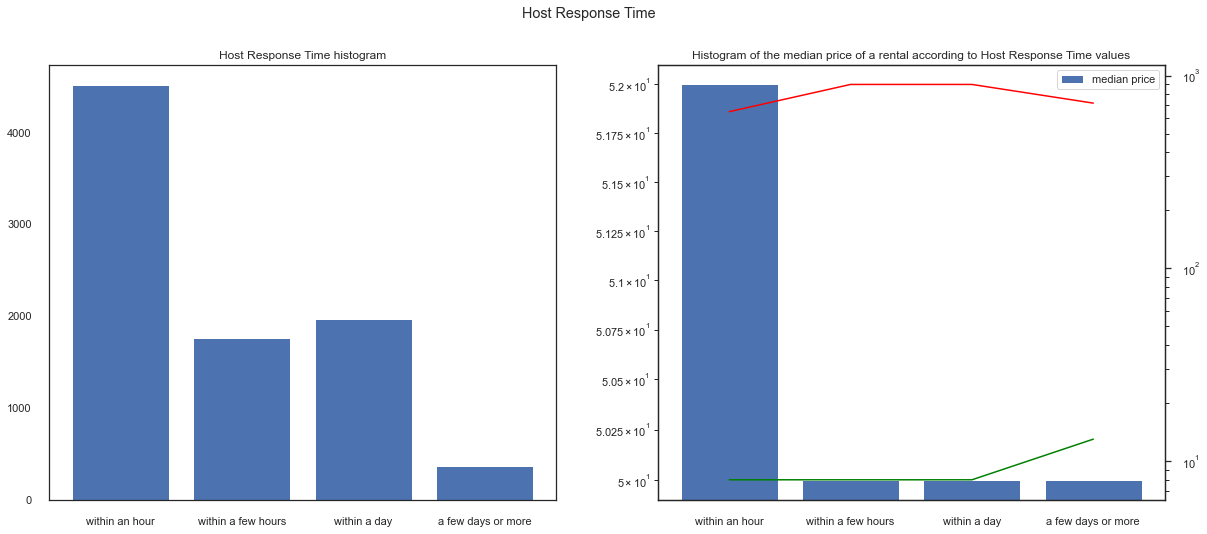

In [33]:
host_resp_time_modalities = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
describe_feature("Host Response Time", host_resp_time_modalities, dataset, mean_or_median='mean', display_hist=False)
describe_feature("Host Response Time", host_resp_time_modalities, dataset, mean_or_median='median', display_hist=False)

In [34]:
dataset.pivot_table(
    index=["Host Response Time"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Host Response Time,,,,
a few days or more,13.0,720.0,62.427793,50.0
within a day,8.0,900.0,62.788403,50.0
within a few hours,8.0,900.0,66.585933,50.0
within an hour,8.0,650.0,68.459220,52.0
All,8.0,900.0,66.523234,50.0


##### Correlation

In [35]:
dataset_host_resp_time_corr = dataset.copy(deep=True)[["Price", "Host Response Time"]]
ord_enc = OrdinalEncoder()
dataset_host_resp_time_corr[["Host Response Time"]] = ord_enc.fit_transform(dataset_host_resp_time_corr[["Host Response Time"]])
dataset_host_resp_time_corr.corr()

,Price,Host Response Time
Price,1.000000,0.044366
Host Response Time,0.044366,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> We could use the year when the host create its account even if the correlations are low.
</div>

<a href="#top">back to top</a>

#### Host Response Rate

##### Missing Values

In [36]:
missing_values_rate_display("Host Response Rate", dataset)

Missing value for Host Response Rate columns: 45.087% (7075/15692)
Star value for Host Response Rate columns: 1.109% (174/15692)


##### Analysis

In [37]:
dataset_resp_rate = dataset_exp[["Host Response Rate","Price"]].dropna()
dataset_resp_rate = dataset_resp_rate.drop(dataset_resp_rate[dataset_resp_rate["Host Response Rate"] == "*"].index)
dataset_resp_rate["Host Response Rate"] = dataset_resp_rate["Host Response Rate"].apply(lambda x:x[:-1]).astype("int")

In [38]:
print(sorted(dataset_resp_rate["Host Response Rate"].unique()))

[0, 20, 25, 30, 33, 40, 50, 58, 60, 63, 67, 70, 71, 75, 78, 80, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


<div class="alert alert-block alert-info">
<b>First breakdown (based on distribution):</b><br>
<ul>
  <li>Rate &lt 1%</li>
  <li>1% &lt= Rate &lt 50%</li>
  <li>50% &lt= Rate &lt 60%</li>
  <li>60% &lt= Rate &lt 70%</li>
  <li>70% &lt= Rate &lt 80%</li>
  <li>80% &lt= Rate &lt 85%</li>
  <li>85% &lt= Rate &lt 90%</li>
  <li>90% &lt= Rate &lt 95%</li>
  <li>95% &lt= Rate &lt 100%</li>
  <li>Rate = 100%</li>
</ul>
</div>

In [39]:
resp_rate_vc = dataset_resp_rate["Host Response Rate"].value_counts()
bornes_basses = [0,1,50,60,70,80,85,90,95,100]
bornes_hautes = [1,50,60,70,80,85,90,95,100,101]
for bb, bh in zip(bornes_basses, bornes_hautes):
    nb = resp_rate_vc[(resp_rate_vc.index>=bb)&(resp_rate_vc.index<bh)].sum()
    print(f"{bb} <= Rate < {bh}: {nb} - {100*nb/resp_rate_vc.sum():.2f}%")

0 <= Rate < 1: 184 - 2.18%
1 <= Rate < 50: 140 - 1.66%
50 <= Rate < 60: 189 - 2.24%
60 <= Rate < 70: 204 - 2.42%
70 <= Rate < 80: 257 - 3.05%
80 <= Rate < 85: 297 - 3.52%
85 <= Rate < 90: 208 - 2.47%
90 <= Rate < 95: 582 - 6.90%
95 <= Rate < 100: 127 - 1.51%
100 <= Rate < 101: 6246 - 74.06%


In [40]:
# We transform this variable into a categorical one
dataset_resp_rate["Host Response Rate cat v1"] = dataset_resp_rate["Host Response Rate"]
resp_rate_cats = []
for bb, bh in zip(bornes_basses, bornes_hautes):
    name = f"{bb}-{bh}%"
    resp_rate_cats.append(name)
    dataset_resp_rate["Host Response Rate cat v1"].replace(
        list(range(bb,bh)), name, inplace=True
    )

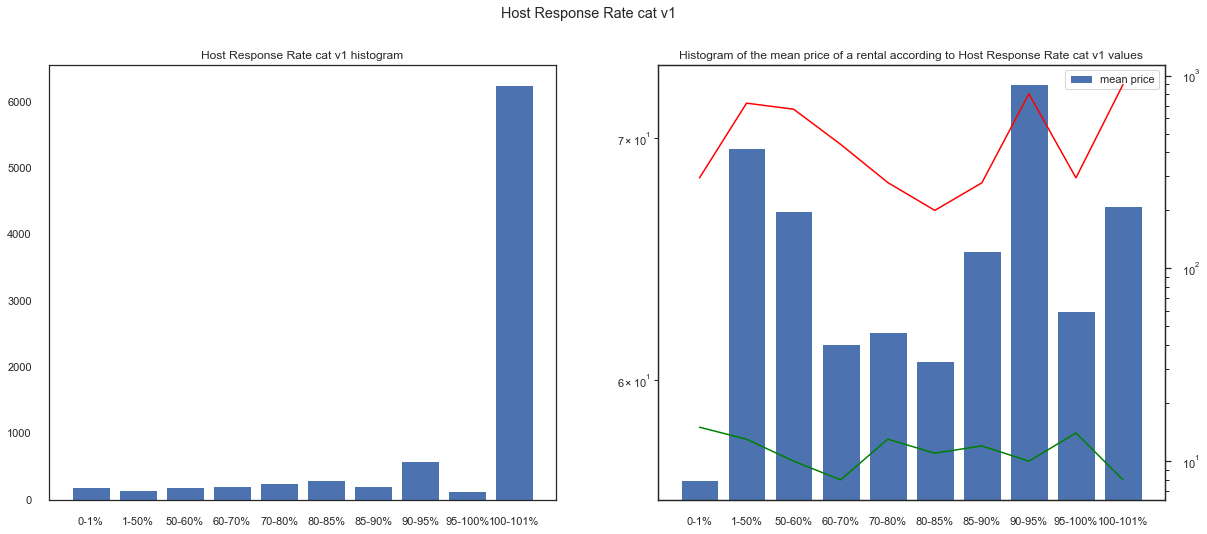

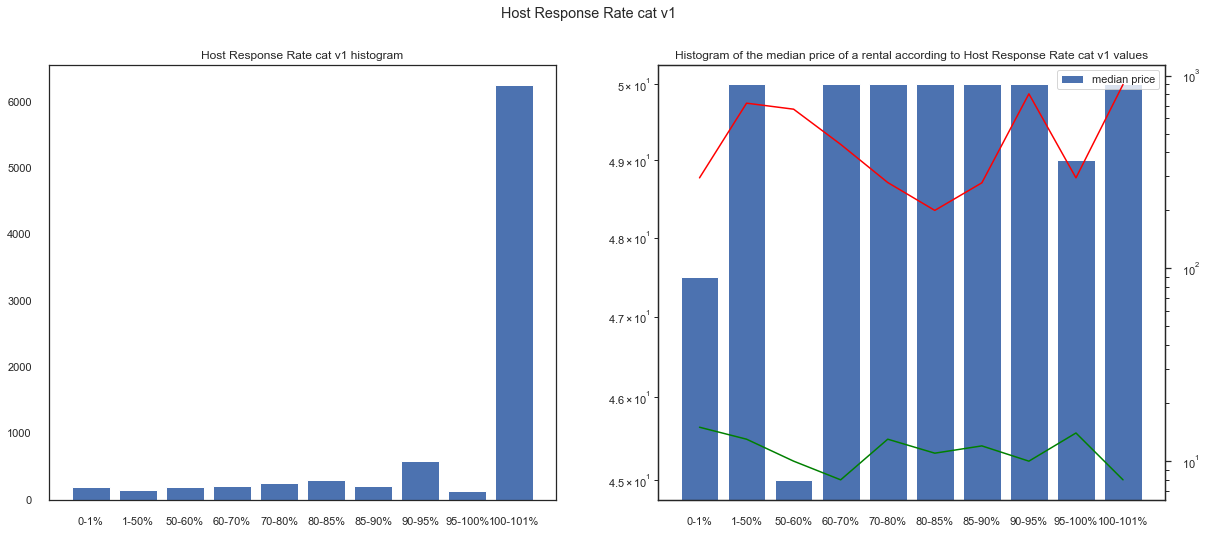

In [41]:
describe_feature("Host Response Rate cat v1", resp_rate_cats, dataset_resp_rate, mean_or_median='mean', display_hist=False)
describe_feature("Host Response Rate cat v1", resp_rate_cats, dataset_resp_rate, mean_or_median='median', display_hist=False)

<div class="alert alert-block alert-info">
<b>Second breakdown (based on distribution):</b><br>
<ul>
  <li>Rate &lt 1%</li>
  <li>1% &lt= Rate &lt 100%</li>
  <li>Rate = 100%</li>
</ul>
</div>

In [42]:
resp_rate_vc = dataset_resp_rate["Host Response Rate"].value_counts()
bornes_basses = [0,1,100]
bornes_hautes = [1,100,101]
for bb, bh in zip(bornes_basses, bornes_hautes):
    nb = resp_rate_vc[(resp_rate_vc.index>=bb)&(resp_rate_vc.index<bh)].sum()
    print(f"{bb} <= Rate < {bh}: {nb} - {100*nb/resp_rate_vc.sum():.2f}%")

0 <= Rate < 1: 184 - 2.18%
1 <= Rate < 100: 2004 - 23.76%
100 <= Rate < 101: 6246 - 74.06%


In [43]:
# We transform this variable into a categorical one
dataset_resp_rate["Host Response Rate cat v2"] = dataset_resp_rate["Host Response Rate"]
resp_rate_cats = []
for bb, bh in zip(bornes_basses, bornes_hautes):
    name = f"{bb}-{bh}%"
    resp_rate_cats.append(name)
    dataset_resp_rate["Host Response Rate cat v2"].replace(
        list(range(bb,bh)), name, inplace=True
    )

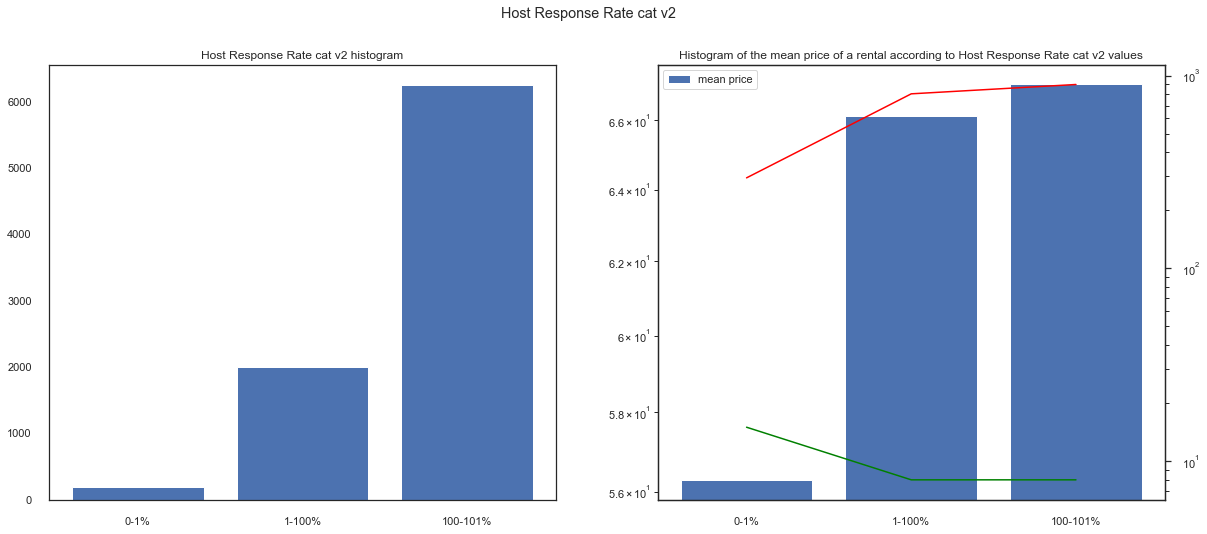

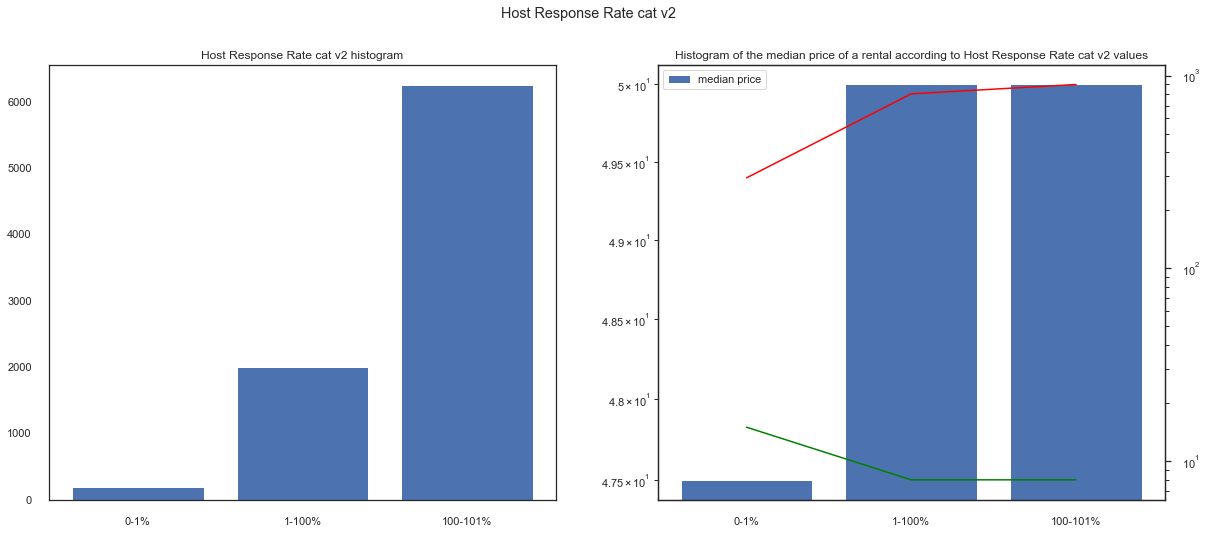

In [44]:
describe_feature("Host Response Rate cat v2", resp_rate_cats, dataset_resp_rate, mean_or_median='mean', display_hist=False)
describe_feature("Host Response Rate cat v2", resp_rate_cats, dataset_resp_rate, mean_or_median='median', display_hist=False)

##### Correlation

In [45]:
dataset_resp_rate_corr = dataset_resp_rate.copy(deep=True)[["Price", "Host Response Rate", 
                                                            "Host Response Rate cat v1", "Host Response Rate cat v2"]]
ord_enc = OrdinalEncoder()
dataset_resp_rate_corr[["Host Response Rate cat v1", "Host Response Rate cat v2"]] = ord_enc.fit_transform(dataset_resp_rate_corr[["Host Response Rate cat v1", "Host Response Rate cat v2"]])
dataset_resp_rate_corr.corr()

,Price,Host Response Rate,Host Response Rate cat v1,Host Response Rate cat v2
Price,1.000000,0.027569,0.006687,0.021206
Host Response Rate,0.027569,1.000000,-0.034160,0.818135
Host Response Rate cat v1,0.006687,-0.034160,1.000000,-0.589536
Host Response Rate cat v2,0.021206,0.818135,-0.589536,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> It seems unnecessary to try to create a division. This variable bring too few informations.
</div>

<a href="#top">back to top</a>

#### Is Superhost

##### Missing Values

In [46]:
missing_values_rate_display("Is Superhost", dataset)

Missing value for Is Superhost columns: 0.147% (23/15692)
Star value for Is Superhost columns: 0.000% (0/15692)


##### Analysis

In [47]:
dataset_superhost = dataset_exp[["Is Superhost",'Price']]
dataset_superhost = dataset_superhost.dropna()
dataset_superhost["Is Superhost"] = dataset_superhost["Is Superhost"].replace(["f","t"],["Not Superhost", "Superhost"])

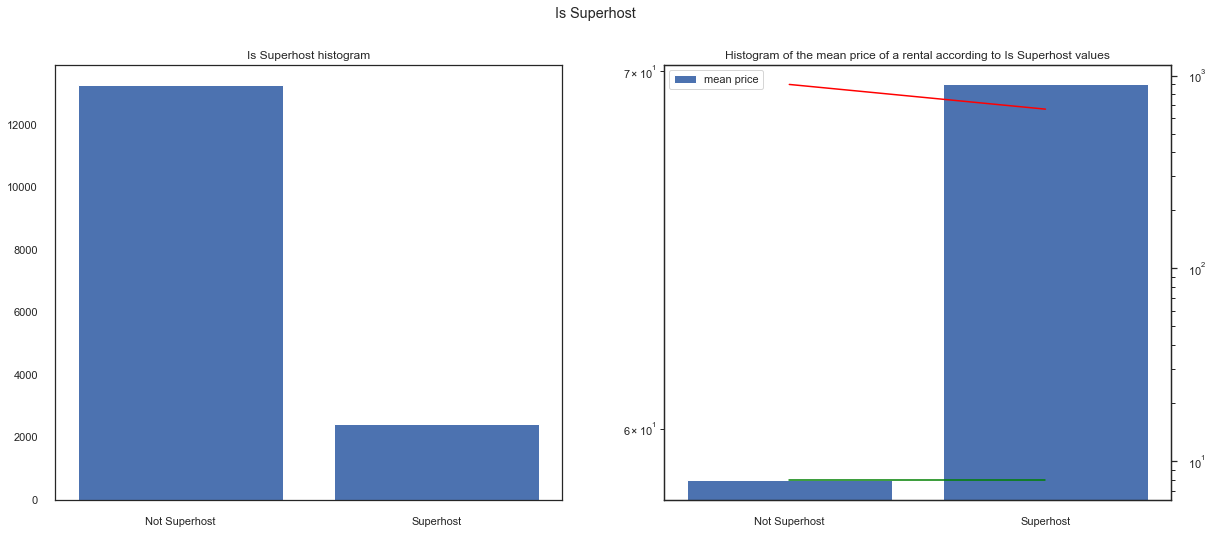

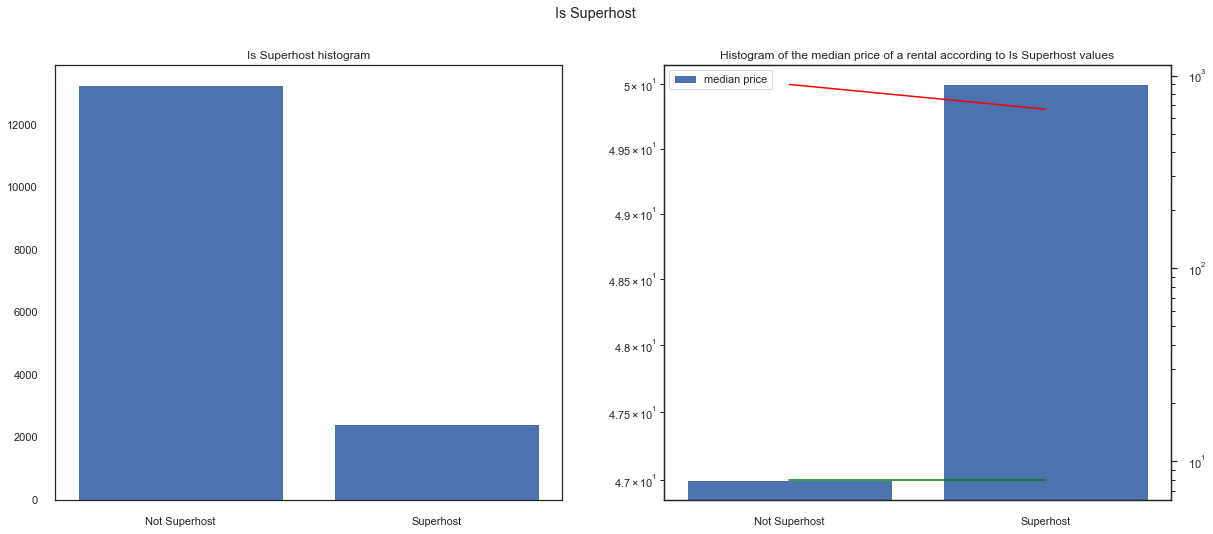

In [48]:
is_super_values = dataset_superhost["Is Superhost"].unique()
describe_feature("Is Superhost", is_super_values, dataset_superhost, mean_or_median='mean', display_hist=False)
describe_feature("Is Superhost", is_super_values, dataset_superhost, mean_or_median='median', display_hist=False)

In [49]:
dataset.pivot_table(
    index=["Host Response Time"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Host Response Time,,,,
a few days or more,13.0,720.0,62.427793,50.0
within a day,8.0,900.0,62.788403,50.0
within a few hours,8.0,900.0,66.585933,50.0
within an hour,8.0,650.0,68.459220,52.0
All,8.0,900.0,66.523234,50.0


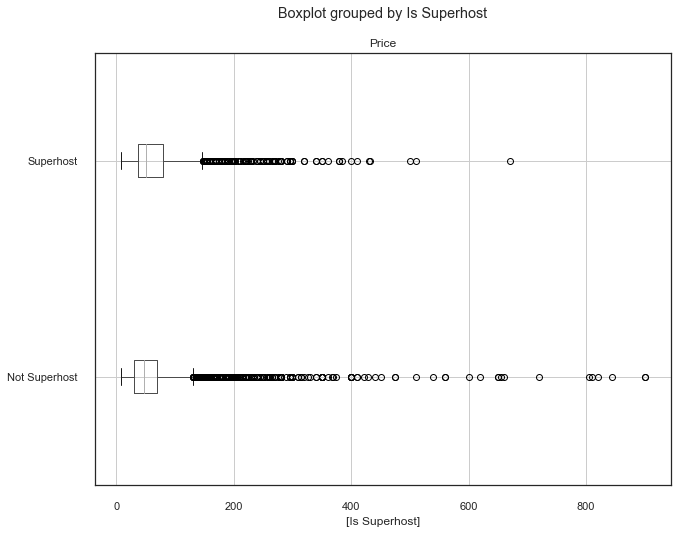

In [50]:
dataset_superhost.boxplot(by = 'Is Superhost', figsize=(10, 8), vert=False)
plt.show()

##### Correlation

In [51]:
dataset_superhost_corr = dataset_superhost.copy(deep=True)[["Price", "Is Superhost"]]
ord_enc = OrdinalEncoder()
dataset_superhost_corr[["Host Response Time"]] = ord_enc.fit_transform(dataset_superhost_corr[["Is Superhost"]])
dataset_superhost_corr.corr()

,Price,Host Response Time
Price,1.000000,0.080518
Host Response Time,0.080518,1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable bring too few informations but we will keep it at first in our model.
</div>

<a href="#top">back to top</a>

#### neighbourhood

##### Missing Values

In [52]:
missing_values_rate_display("neighbourhood", dataset)

Missing value for neighbourhood columns: 0.000% (0/15692)
Star value for neighbourhood columns: 1.294% (203/15692)


##### Analysis

In [53]:
dataset_neigh = dataset_exp[dataset_exp["neighbourhood"]!="*"]

In [54]:
print(dataset_neigh["neighbourhood"].unique().shape[0], "neighbourhoods")
equal_neigh_group = 100*dataset_neigh.apply(lambda x: x.loc["neighbourhood"]==x.loc["Neighborhood Group"], axis=1).mean()
print(f"{equal_neigh_group:.1f}% neighbourhoods equal neighbourhood groups")

62 neighbourhoods
27.1% neighbourhoods equal neighbourhood groups


<div class="alert alert-block alert-info">
<p><b>Rq: </b>This second information (27.1% neighbourhoods equal neighbourhood groups) is interesting because since there are no missing values for the 'Neighbordhood Group' feature (more information in the related section), we could simply replace the values with a star by the 'Neighbordhood Group' value of the relative instance</p>
</div>

In [55]:
dataset_neigh.pivot_table(
    index=["neighbourhood"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
neighbourhood,,,,
Adlershof,14.0,110.0,48.631579,30.0
Alt-HohenschÃ¶nhausen,17.0,125.0,44.375000,38.0
Alt-Treptow,15.0,279.0,54.349593,45.0
Altglienicke,17.0,120.0,46.588235,30.0
Baumschulenweg,10.0,145.0,42.109375,35.5
...,...,...,...,...
Wilhelmstadt,30.0,290.0,80.250000,56.5
Wilmersdorf,13.0,650.0,67.739264,50.0


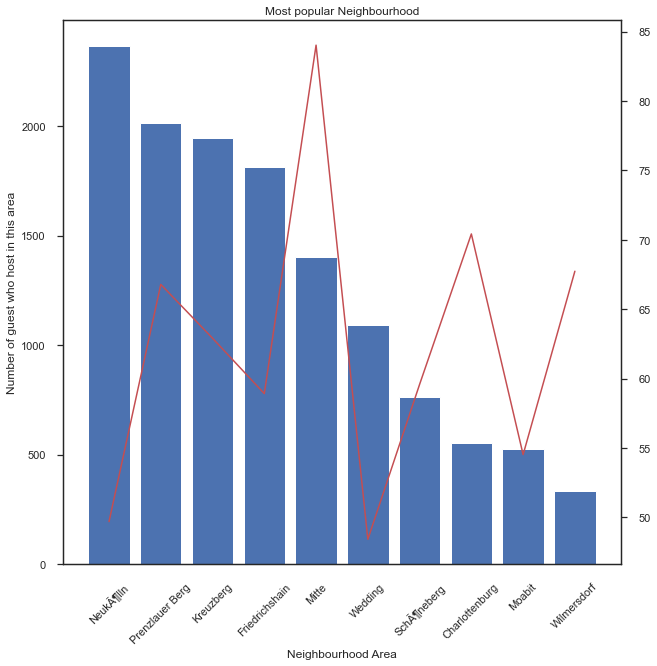

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
data = dataset_neigh["neighbourhood"].value_counts()[:10]
mean_price = dataset_neigh[["neighbourhood", "Price"]].groupby(["neighbourhood"])["Price"].mean().reindex(data.index)[:10]

x = data.index
y_ = data.values

plt.title("Most popular Neighbourhood")
plt.xlabel("Neighbourhood Area")
plt.ylabel("Number of guest who host in this area")
plt.xticks(rotation=45)
plt.bar(x,y_)

ax2=ax.twinx()

plt.plot(mean_price.index, mean_price.values, c="r")

plt.show()

<div class="alert alert-block alert-info">
    <b>Encoding idea:</b><br>
    <p>As the feature contains too much possible values, using a OneHotEncoder would not be relevant. Then, we have considered another encoder: LeaveOneOutEncoder.</p>
    <p><b>Idea: </b>We take the mean of a variable for all rows with the same id except for the current row, so as to avoid leakage.</p>
</div>

##### Correlation

In [57]:
dataset_neigh_X = dataset_neigh[["neighbourhood"]]
dataset_neigh_y = dataset_neigh[ "Price"]
encoder = ce.LeaveOneOutEncoder(cols=["neighbourhood"])
encoder.fit(dataset_neigh_X, dataset_neigh_y)
dataset_neigh_X = encoder.transform(dataset_neigh_X)
dataset_neigh_X["Price"] = dataset_neigh_y
dataset_neigh_X.corr()

,neighbourhood,Price
neighbourhood,1.000000,0.217822
Price,0.217822,1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable can be interesting to use with the LeaveOneOut Encoder
</div>

<a href="#top">back to top</a>

#### Neighborhood Group

##### Missing Values

In [58]:
missing_values_rate_display("Neighborhood Group", dataset)

Missing value for Neighborhood Group columns: 0.000% (0/15692)
Star value for Neighborhood Group columns: 0.000% (0/15692)


##### Analysis

In [59]:
print(dataset["Neighborhood Group"].unique().shape[0], "Neighborhood Group")

12 Neighborhood Group


In [60]:
dataset.pivot_table(
    index=["Neighborhood Group"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Neighborhood Group,,,,
Charlottenburg-Wilm.,8.0,650.0,68.653447,51.0
Friedrichshain-Kreuzberg,8.0,450.0,61.033439,50.0
Lichtenberg,11.0,475.0,51.028846,42.0
Marzahn - Hellersdorf,13.0,276.0,57.188976,45.0
Mitte,8.0,845.0,66.632840,50.0
NeukÃ¶lln,10.0,660.0,49.642915,40.0
Pankow,9.0,900.0,64.868985,50.0
Reinickendorf,8.0,340.0,45.247706,36.0


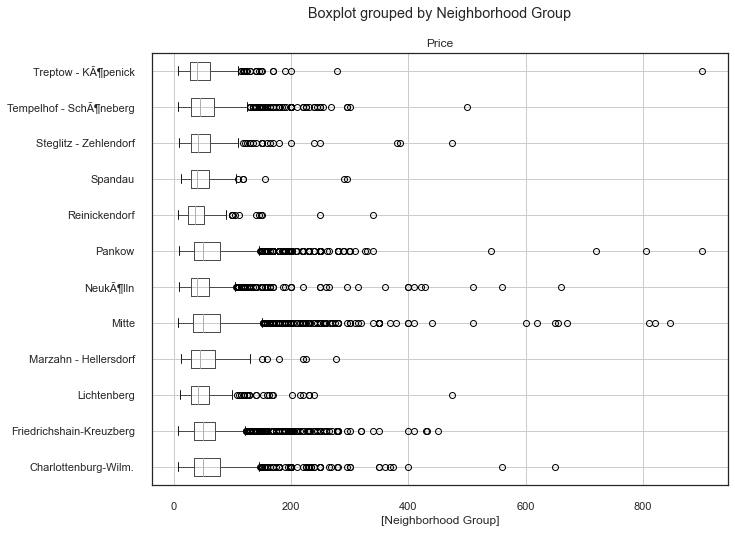

In [61]:
dataset[['Neighborhood Group','Price']].boxplot(by = 'Neighborhood Group', figsize=(10, 8), vert=False)
plt.show()

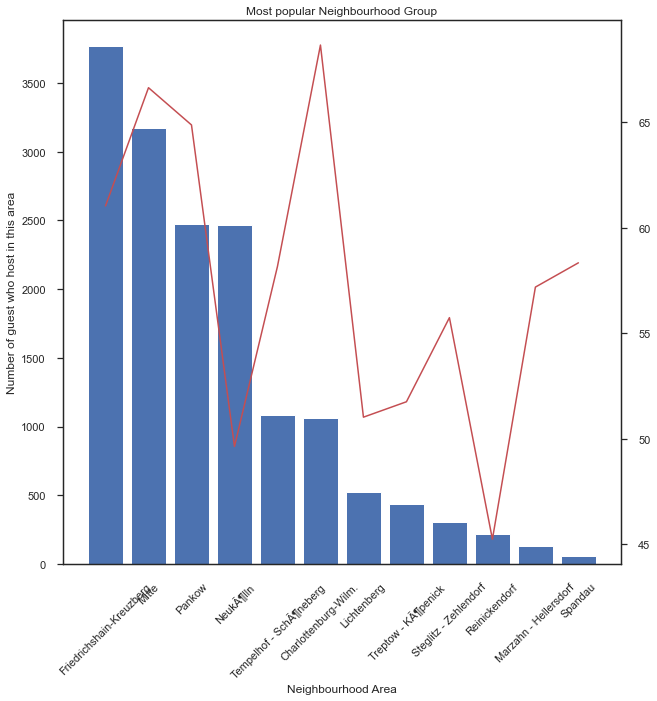

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
data = dataset["Neighborhood Group"].value_counts()
mean_price = dataset[["Neighborhood Group", "Price"]].groupby(["Neighborhood Group"])["Price"].mean().reindex(data.index)

x = data.index
y_ = data.values

plt.title("Most popular Neighbourhood Group")
plt.xlabel("Neighbourhood Area")
plt.ylabel("Number of guest who host in this area")
plt.xticks(rotation=45)
plt.bar(x,y_)

ax2=ax.twinx()

plt.plot(mean_price.index, mean_price.values, c="r")

plt.show()

##### Correlation

In [63]:
dataset_neighG_X = dataset[["Neighborhood Group"]]
dataset_neighG_y = dataset[ "Price"]
encoder = ce.LeaveOneOutEncoder(cols=["Neighborhood Group"])
encoder.fit(dataset_neighG_X, dataset_neighG_y)
dataset_neighG_X = encoder.transform(dataset_neighG_X)
dataset_neighG_X["Price"] = dataset_neighG_y
dataset_neighG_X["neighbourhood"] = dataset_neigh_X["neighbourhood"]
dataset_neighG_X.corr()

,Neighborhood Group,Price,neighbourhood
Neighborhood Group,1.000000,0.134236,0.612838
Price,0.134236,1.000000,0.217822
neighbourhood,0.612838,0.217822,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> This variable can be interesting to use with the LeaveOneOut Encoder but it gives redondancy (coeff of correlation equal to 0.61) with the neighboroud feature who has the highest correlation
</div>

<a href="#top">back to top</a>

#### Postal Code

##### Missing Values

In [64]:
missing_values_rate_display("Postal Code", dataset)

Missing value for Postal Code columns: 1.459% (229/15692)
Star value for Postal Code columns: 5.544% (870/15692)


##### Correlation

In [65]:
dataset_pc = dataset[["Postal Code", "neighbourhood", "Neighborhood Group"]].copy()

<div class="alert alert-block alert-warning">
<b>Conlusion:</b> This variable creates data redundancy with neighborhood
</div>

<a href="#top">back to top</a>

#### Latitude & Longitude

##### Missing Values

In [66]:
missing_values_rate_display("Latitude", dataset)

Missing value for Latitude columns: 0.000% (0/15692)
Star value for Latitude columns: 0.000% (0/15692)


In [67]:
missing_values_rate_display("Longitude", dataset)

Missing value for Longitude columns: 0.000% (0/15692)
Star value for Longitude columns: 0.000% (0/15692)


##### Analysis

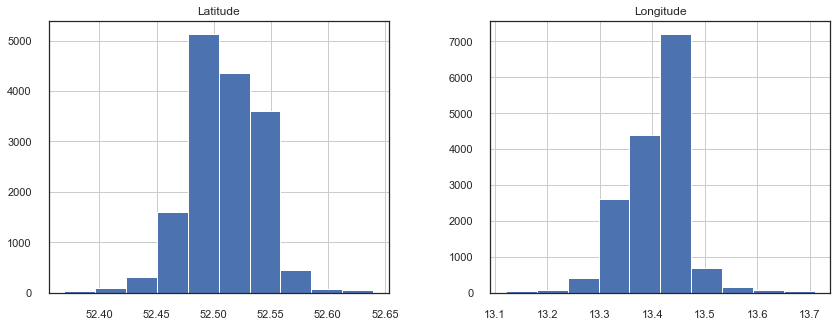

In [68]:
dataset[["Latitude","Longitude"]].hist(figsize=(14,5))
plt.show()

##### Correlation

In [69]:
dataset[["Latitude","Longitude","Price"]].corr()

,Latitude,Longitude,Price
Latitude,1.000000,-0.125704,0.039158
Longitude,-0.125704,1.000000,-0.041581
Price,0.039158,-0.041581,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> This variables create data redundancy with neighborhood. Could be used in feature engineering to compute the location.
</div>

<a href="#top">back to top</a>

#### Is Exact Location

##### Missing Values

In [70]:
missing_values_rate_display("Is Exact Location", dataset)

Missing value for Is Exact Location columns: 0.000% (0/15692)
Star value for Is Exact Location columns: 0.000% (0/15692)


##### Analysis

In [71]:
dataset["Is Exact Location"].value_counts()

t    11596
f     4096
Name: Is Exact Location, dtype: int64

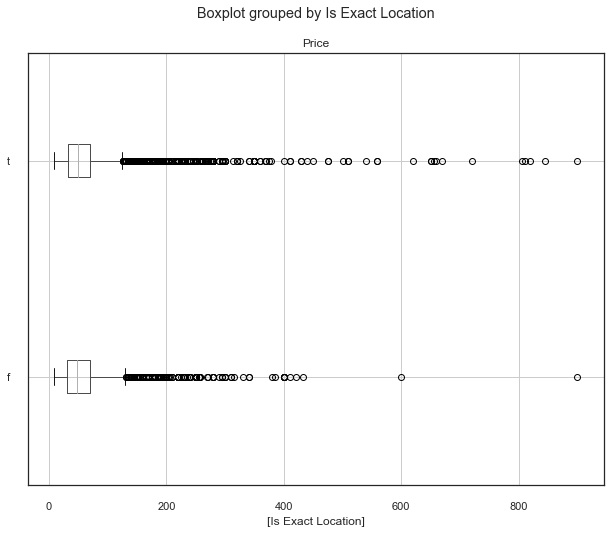

In [72]:
dataset[["Is Exact Location",'Price']].boxplot(by = "Is Exact Location", figsize=(10, 8), vert=False)
plt.show()

In [73]:
dataset.pivot_table(
    index=["Is Exact Location"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Is Exact Location,,,,
f,9.0,900.0,60.067531,48.0
t,8.0,900.0,60.440066,49.0
All,8.0,900.0,60.342983,49.0


##### Categorical Values Encoding

In [74]:
dataset_el = dataset[["Is Exact Location","Price"]].copy()

In [75]:
dataset_el["Is Exact Location"] = dataset_el["Is Exact Location"].replace('t', 1)
dataset_el["Is Exact Location"] = dataset_el["Is Exact Location"].replace('f', 0)

##### Correlation

In [76]:
dataset_el.corr()

,Is Exact Location,Price
Is Exact Location,1.000000,0.003349
Price,0.003349,1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> No correlations
</div>

<a href="#top">back to top</a>

#### Property Type

##### Missing Values

In [77]:
missing_values_rate_display("Property Type", dataset)

Missing value for Property Type columns: 0.000% (0/15692)
Star value for Property Type columns: 0.478% (75/15692)


##### Analysis

In [78]:
# Copy column
dataset_PT = dataset[["Property Type", "Price"]].copy()

In [79]:
# Distinct values
dataset_PT["Property Type"].unique()

array(['Apartment', 'Condominium', 'Bed and breakfast', 'Loft', 'House',
       '*', 'Townhouse', 'Serviced apartment', 'Guesthouse', 'Hostel',
       'Guest suite', 'Bungalow', 'Other', 'Boutique hotel', 'Hotel',
       'Boat'], dtype=object)

In [80]:
print(dataset_PT["Property Type"].value_counts())

Apartment             14132
Condominium             374
Loft                    334
House                   283
Serviced apartment      116
*                        75
Townhouse                68
Hostel                   58
Bed and breakfast        51
Guest suite              49
Other                    42
Hotel                    36
Guesthouse               33
Boutique hotel           19
Bungalow                 15
Boat                      7
Name: Property Type, dtype: int64


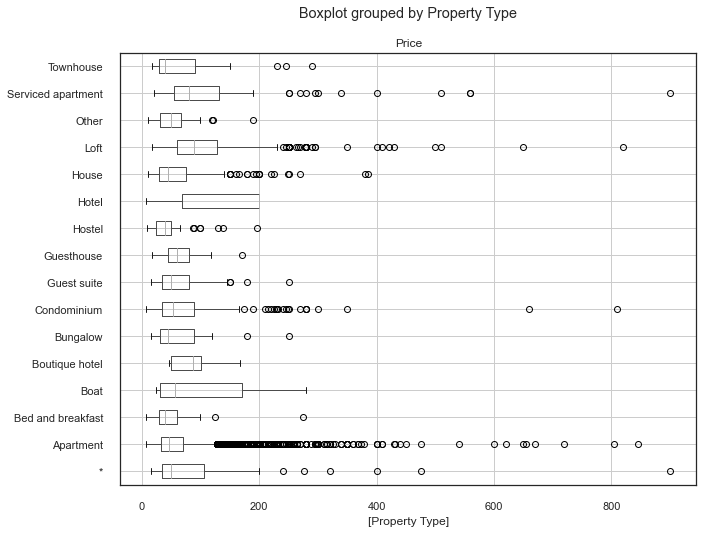

In [81]:
dataset[["Property Type",'Price']].boxplot(by = "Property Type", figsize=(10, 8), vert=False)
plt.show()

##### Categorical Values Encoding

In [82]:
dataset_PT.drop(dataset_PT[dataset_PT["Property Type"] == '*'].index, inplace = True)

In [83]:
## Encoding
encoder= ce.OrdinalEncoder(cols=['Property Type'],
                            return_df=True,
                            mapping=[{'col':'Property Type','mapping':{'Apartment':0, 'Condominium':1, 'Bed and breakfast':2, 'Loft':3, 'House':4,
                        'Townhouse':5, 'Serviced apartment':6, 'Guesthouse':7, 'Hostel':8,'Guest suite':9, 'Bungalow':10, 'Boutique hotel':11, 
                        'Hotel':12,'Boat':13,'Other':14}}])

In [84]:
dataset_PT_enc = encoder.fit_transform(dataset_PT)

In [85]:
dataset_PT_enc.head()

,Property Type,Price
0,0,26.0
1,0,41.0
2,0,50.0
3,0,50.0
4,0,55.0


In [86]:
new_features["Property Type enc"] = dataset_PT_enc["Property Type"]

##### Correlation

In [87]:
print(dataset_PT_enc.corr())

               Property Type     Price
Property Type       1.000000  0.118445
Price               0.118445  1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Low correlations
</div>

<a href="#top">back to top</a>

#### Room Type

##### Missing Values

In [88]:
missing_values_rate_display("Room Type", dataset)

Missing value for Room Type columns: 0.000% (0/15692)
Star value for Room Type columns: 0.000% (0/15692)


##### Analysis

Private room       7877
Entire home/apt    7666
Shared room         149
Name: Room Type, dtype: int64


Text(0.5, 0, 'Number of Room Types and average price')

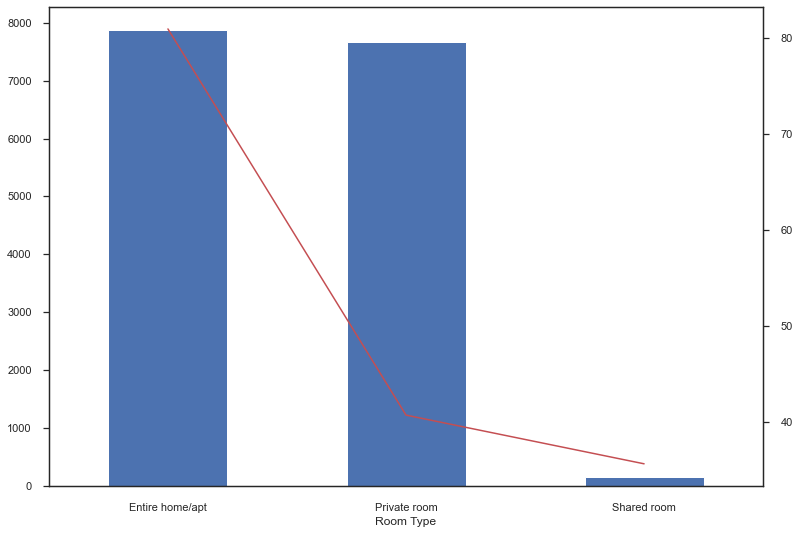

In [89]:
# Copy column
dataset_RT = dataset[["Room Type", "Price"]].copy()
#Compute average price by room type
avg_price_RT = dataset_RT.groupby("Room Type")['Price'].mean();

print(dataset_RT["Room Type"].value_counts())

#Plot Room Types and Price
fig, ax = plt.subplots()
dataset_RT["Room Type"].value_counts().plot.bar(rot=0)
avg_price_RT.plot(ax=ax, style='r-',secondary_y=True)
plt.xlabel("Number of Room Types and average price")

Very few Shared rooms in the dataset. We must be carefull if we include it in the models.

##### Categorical Values Encoding

In [90]:
## One hot
#Creation de Dummy values
dummies = []
dummies.append(pd.get_dummies(dataset["Room Type"])) #liste
tab_dummies = pd.concat(dummies, axis=1) #tableau
new_features = pd.concat((new_features, tab_dummies), axis=1)

In [91]:
## Numerical Encoding
num_encoding = {"Room Type": {"Entire home/apt": 1.0, "Private room": 2.0, "Shared room": 3.0}}
copy = dataset.copy()
copy = copy.replace(num_encoding)
RT_num = pd.DataFrame(copy["Room Type"])
RT_num.columns = ["Room Type - num"]
new_features = pd.concat((new_features, RT_num), axis=1)

##### Correlation

In [92]:
dataset_room = new_features[["Entire home/apt", "Private room", "Shared room", "Room Type - num"]]
dataset_room = pd.concat((dataset_room, dataset["Price"]), axis=1)
corr_matrix_room = dataset_room.corr()
corr_room = corr_matrix_room["Price"].sort_values(ascending = False)
print(corr_room)

Price              1.000000
Entire home/apt    0.412322
Shared room       -0.049296
Private room      -0.402689
Room Type - num   -0.407001
Name: Price, dtype: float64


Better correlation with the one hot.

<div class="alert alert-block alert-success">
<b>Conlusion:</b> Very high correlations of encoded variable "Entire home/apt"
</div>

<a href="#top">back to top</a>

#### Accomodates

##### Missing Values

In [93]:
missing_values_rate_display("Accomodates", dataset)

Missing value for Accomodates columns: 0.000% (0/15692)
Star value for Accomodates columns: 0.121% (19/15692)


Très peu de valeurs manquantes, on peut les drop  pour faire l'analyse.

In [94]:
dataset_acc = dataset[["Accomodates", "Price"]].copy()
dataset_acc.drop(dataset_acc[dataset_acc["Accomodates"] == '*'].index, inplace = True)
dataset_acc["Accomodates"] = dataset_acc["Accomodates"].astype(float)

##### Analysis

Text(0.5, 0, 'Number of Accomodates and average price')

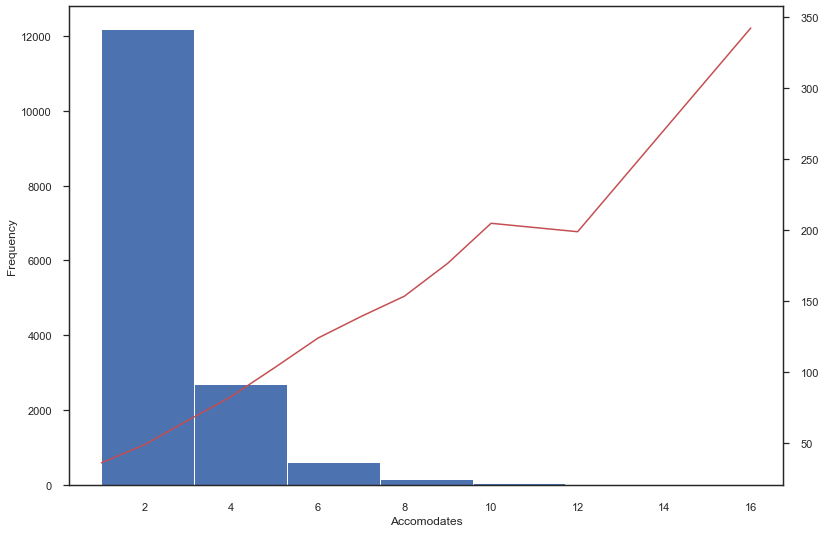

In [95]:
#Compute average price
avg_price_acc = dataset_acc.groupby("Accomodates")['Price'].mean().sort_index();
#print(avg_price_acc)
#print(dataset["Accomodates"].value_counts())

#Plot Accomodates and Price
fig, ax = plt.subplots()
dataset_acc["Accomodates"].plot(ax=ax, style='g-',kind='hist', bins = 7)
avg_price_acc.plot(ax=ax, style='r-',secondary_y=True)
plt.xlabel("Number of Accomodates and average price")

##### Correlation

In [96]:
corr_acc = dataset_acc.corr()
print(corr_acc)

             Accomodates     Price
Accomodates     1.000000  0.505274
Price           0.505274  1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Very high correlations
</div>

<a href="#top">back to top</a>

#### Bathrooms

In [97]:
missing_values_rate_display("Bathrooms", dataset)

Missing value for Bathrooms columns: 0.089% (14/15692)
Star value for Bathrooms columns: 0.070% (11/15692)


In [98]:
dataset_bath = dataset[["Bathrooms","Price"]].copy()
dataset_bath = dataset_bath.dropna(subset=["Bathrooms"])
dataset_bath.drop(dataset_bath[dataset_bath["Bathrooms"] == '*'].index, inplace = True)

##### Analysis

In [99]:
##Type conversion
dataset_bath["Bathrooms"] = dataset_bath["Bathrooms"].astype(float)

Text(0.5, 0, 'Number of Bathrooms and average price')

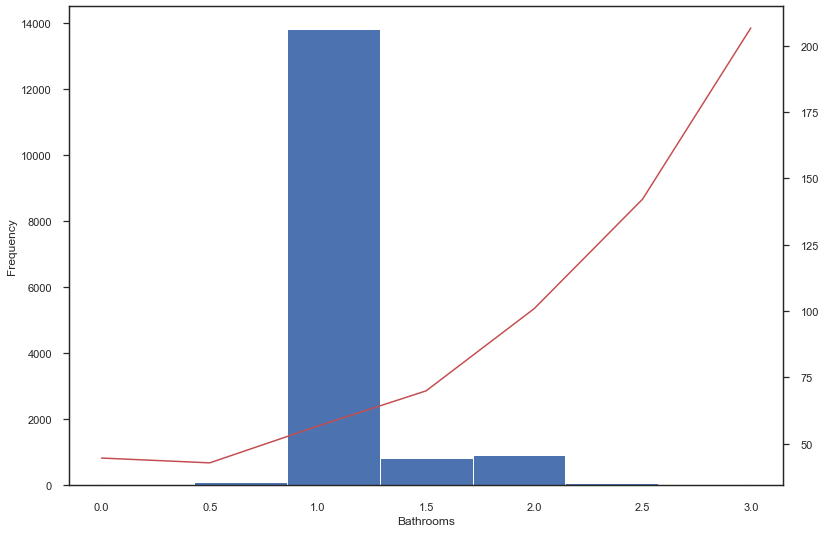

In [100]:
#Compute average price
avg_price_bath = dataset_bath.groupby("Bathrooms")['Price'].mean().sort_index();

#Plot Bathrooms and Price
fig, ax = plt.subplots()
dataset_bath["Bathrooms"].plot(ax=ax, style='g-',kind='hist', bins = 7)
avg_price_bath.plot(ax=ax, style='r-',secondary_y=True)
plt.xlabel("Number of Bathrooms and average price")

##### Correlation

In [101]:
corr_bath = dataset_bath.corr()
print(corr_bath)

           Bathrooms     Price
Bathrooms   1.000000  0.257354
Price       0.257354  1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> Low correlation
</div>

<a href="#top">back to top</a>

#### Bedrooms

##### Missing Values

In [102]:
missing_values_rate_display("Bedrooms", dataset)

Missing value for Bedrooms columns: 0.032% (5/15692)
Star value for Bedrooms columns: 0.070% (11/15692)


##### Categorical Values Encoding

In [103]:
#Copying dataset and dropping * and na
dataset_BR = dataset[["Bedrooms", "Price"]].copy()
dataset_BR = dataset_BR.dropna(subset=["Bedrooms"])
dataset_BR.drop(dataset_BR[dataset_BR["Bedrooms"] == '*'].index, inplace = True)

#Type conversion
dataset_BR["Bedrooms"] = dataset_BR["Bedrooms"].astype(float)

##### Analysis

Text(0.5, 0, 'Number of Bedrooms and average price')

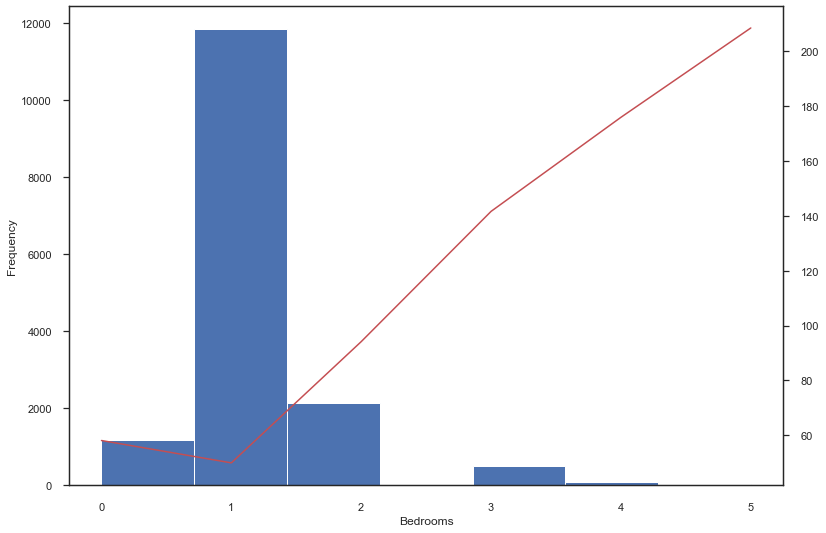

In [104]:
#Compute average price
avg_price_BR = dataset_BR.groupby("Bedrooms")['Price'].mean().sort_index();

#Plot Bedrooms and Price
fig, ax = plt.subplots()
dataset_BR["Bedrooms"].plot(ax=ax, style='g-',kind='hist', bins = 7)
avg_price_BR.plot(ax=ax, style='r-',secondary_y=True)
plt.xlabel("Number of Bedrooms and average price")

##### Correlation

In [105]:
corr_BR = dataset_BR.corr()
print(corr_BR)

          Bedrooms     Price
Bedrooms  1.000000  0.411974
Price     0.411974  1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Good correlations
</div>

<a href="#top">back to top</a>

#### Beds 

##### Missing values

In [106]:
missing_values_rate_display("Beds", dataset)

Missing value for Beds columns: 0.051% (8/15692)
Star value for Beds columns: 0.076% (12/15692)


In [107]:
dataset["Beds"].unique()

array(['1.0', '2.0', '4.0', '8.0', '6.0', '5.0', '3.0', '7.0', nan, '9.0',
       '10.0', '*', '0.0'], dtype=object)

If the value is nan, 0, or * we can impute beds = bedrooms

In [108]:
#for el in dataset["Beds"].values:
#    if el in (0.0, '*', np.nan):
#        el = dataset["Bedrooms"]
##A COMPLETER

##### Analysis

In [109]:
#Copying dataset and dropping * and na
dataset_bed = dataset[["Beds", "Price"]].copy()
dataset_bed = dataset_bed.dropna(subset=["Beds"])
dataset_bed.drop(dataset_bed[dataset_bed["Beds"] == '*'].index, inplace = True)

#Type conversion
dataset_bed["Beds"] = dataset_bed["Beds"].astype(float)

Text(0.5, 0, 'Number of Beds and average price')

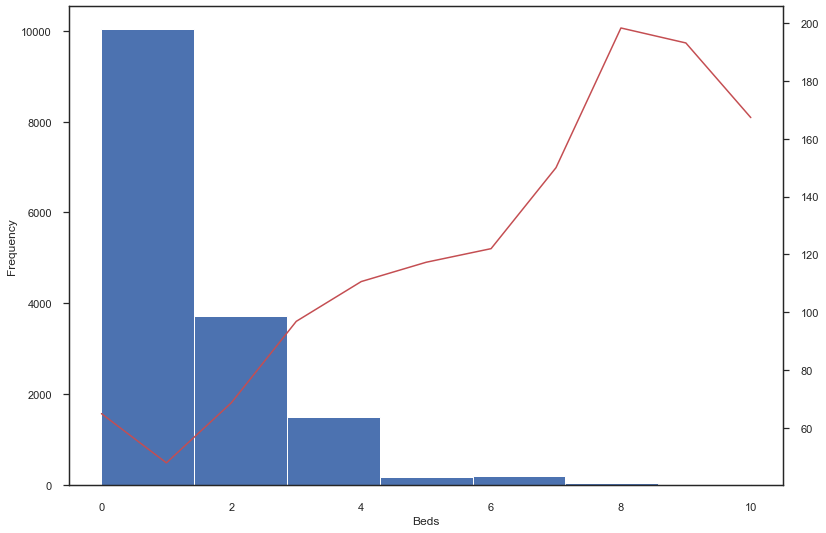

In [110]:
#Compute average price
avg_price_bed = dataset_bed.groupby("Beds")['Price'].mean().sort_index();

#Plot Bedrooms and Price
fig, ax = plt.subplots()
dataset_bed["Beds"].plot(ax=ax, style='g-',kind='hist', bins = 7)
avg_price_bed.plot(ax=ax, style='r-',secondary_y=True)
plt.xlabel("Number of Beds and average price")

##### Correlation

In [111]:
corr_bed = dataset_bed.corr()
print(corr_bed)

          Beds    Price
Beds   1.00000  0.42079
Price  0.42079  1.00000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Good correlations. It can be redundant with Bedrooms though.
</div>

<a href="#top">back to top</a>

#### Guests Included

##### Missing Values

In [112]:
missing_values_rate_display("Guests Included", dataset)

Missing value for Guests Included columns: 0.000% (0/15692)
Star value for Guests Included columns: 0.064% (10/15692)


In [113]:
dataset_gi = dataset[["Guests Included", "Price"]].copy()
dataset_gi.drop(dataset_gi[dataset_gi["Guests Included"] == '*'].index, inplace = True)
dataset_gi["Guests Included"] = dataset_gi["Guests Included"].astype(float)

##### Analysis

Text(0.5, 0, 'Number of Guests Included and average price')

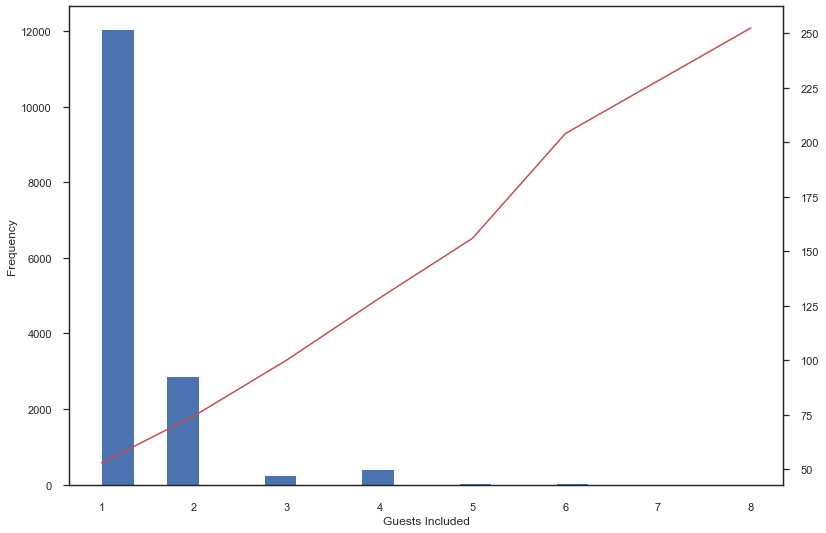

In [114]:
#Compute average price
avg_price_gi = dataset_gi.groupby("Guests Included")['Price'].mean().sort_index();

#Plot Guests and Price
fig, ax = plt.subplots()
dataset_gi["Guests Included"].plot(ax=ax, style='g-',kind='hist', bins = 20)
avg_price_gi.plot(ax=ax, style='r-',secondary_y=True)
plt.xlabel("Number of Guests Included and average price")

##### Correlation

In [115]:
corr_gi = dataset_gi.corr()
print(corr_gi)

                 Guests Included     Price
Guests Included         1.000000  0.367821
Price                   0.367821  1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Good correlation. Again, can be redundant with Beds and Bedrooms.
</div>

<a href="#top">back to top</a>

#### Min Nights

##### Missing Values

In [116]:
missing_values_rate_display("Min Nights", dataset)

Missing value for Min Nights columns: 0.000% (0/15692)
Star value for Min Nights columns: 1.587% (249/15692)


A lot of star values, we must think as to wether or not it's a good idea to impute them.

##### Analysis

In [117]:
##Type conversion
dataset_nights = dataset.copy()
dataset_nights.drop(dataset_nights[dataset_nights["Min Nights"] == '*'].index, inplace = True)

dataset_nights["Min Nights"] = dataset_nights["Min Nights"].astype(float)

dataset_mn = dataset_nights[["Min Nights", "Price"]].copy()

In [118]:
##Imputation
corr_mn = dataset_nights.corr()
corr_mn["Min Nights"].sort_values(ascending=False)

Min Nights              1.000000
Accuracy Rating         0.036364
Latitude                0.030650
Cleanliness Rating      0.027489
Communication Rating    0.020870
Price                   0.016571
Overall Rating          0.013255
Checkin Rating          0.009407
Location Rating         0.007948
Value Rating           -0.005221
Square Feet            -0.017944
Reviews                -0.032246
Longitude              -0.043054
Host ID                -0.045508
Listing ID             -0.076565
Name: Min Nights, dtype: float64

No clear correlation with other features.
We are going to impite the missing values with the mean of other rows?

Text(0.5, 0, 'Number of Guests Included and average price')

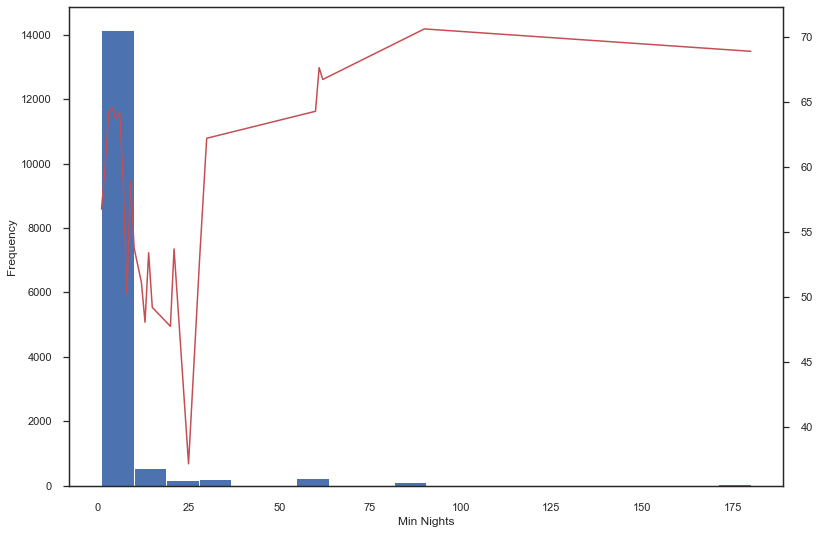

In [119]:
#Compute average price
avg_price_mn = dataset_mn.groupby("Min Nights")['Price'].mean().sort_index();

#Plot Guests and Price
fig, ax = plt.subplots()
dataset_mn["Min Nights"].plot(ax=ax, style='g-',kind='hist', bins = 20)
avg_price_mn.plot(ax=ax, style='r-',secondary_y=True)
plt.xlabel("Number of Guests Included and average price")

##### Correlation

In [120]:
corr_mn = dataset_mn.corr()
print(corr_mn)

            Min Nights     Price
Min Nights    1.000000  0.016571
Price         0.016571  1.000000


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> No correlations
</div>

<a href="#top">back to top</a>

#### Reviews

##### Missing values

In [121]:
missing_values_rate_display("Reviews", dataset)

Missing value for Reviews columns: 0.000% (0/15692)
Star value for Reviews columns: 0.000% (0/15692)


##### Categorical Values Encoding

In [122]:
dataset_reviews = dataset[["Reviews", "Price"]].copy()
dataset_reviews.drop(dataset_reviews[dataset_reviews["Reviews"] == '*'].index, inplace = True)
dataset_reviews["Reviews"] = dataset_reviews["Reviews"].astype(float)

##### Analysis

Text(0.5, 0, 'Number of Reviews and average price')

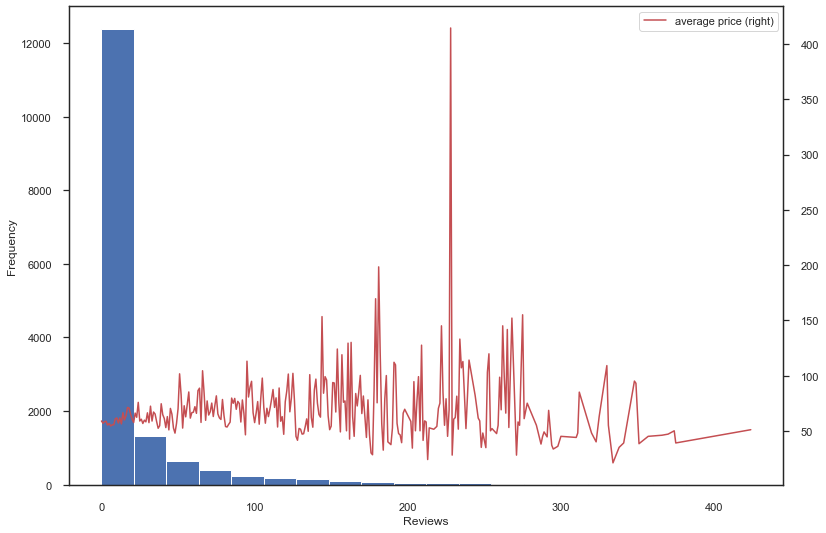

In [123]:
#Compute average price
avg_price_reviews = dataset_reviews.groupby("Reviews")['Price'].mean().sort_index();

#Plot Guests and Price
fig, ax = plt.subplots()
dataset_reviews["Reviews"].plot(ax=ax, style='g-',kind='hist', bins = 20)
avg_price_reviews.plot(ax=ax, style='r-',secondary_y=True, label="average price")
plt.legend()
plt.xlabel("Number of Reviews and average price")

In [124]:
corr_matrix = dataset_reviews.corr()
corr_matrix["Price"]

Reviews    0.078231
Price      1.000000
Name: Price, dtype: float64

<div class="alert alert-block alert-success">
<b>Conlusion:</b> No Correlation. Good be better used in feature engineering to increase correlation.
</div>

<a href="#top">back to top</a>

#### First Review & Last Review

##### Missing values

In [125]:
missing_values_rate_display("First Review", dataset)
missing_values_rate_display("Last Review", dataset)

Missing value for First Review columns: 17.238% (2705/15692)
Star value for First Review columns: 0.000% (0/15692)
Missing value for Last Review columns: 17.244% (2706/15692)
Star value for Last Review columns: 0.000% (0/15692)


##### Categorical Values Encoding

In [126]:
dataset_FL_review=dataset.copy()
dataset_first_review=pd.DataFrame(pd.to_datetime(dataset_FL_review['First Review'].dropna()))
dataset_FL_review['timestamp FR'] = dataset_first_review[['First Review']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
dataset_FL_review['day FR']=pd.to_datetime(dataset_FL_review['First Review']).dt.day
dataset_FL_review['month FR']=pd.to_datetime(dataset_FL_review['First Review']).dt.month
dataset_FL_review['year FR']=pd.to_datetime(dataset_FL_review['First Review']).dt.year

dataset_last_review=pd.DataFrame(pd.to_datetime(dataset_FL_review['Last Review'].dropna()))
dataset_FL_review['timestamp LR'] = dataset_last_review[['Last Review']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
dataset_FL_review['day LR']=pd.to_datetime(dataset_FL_review['Last Review']).dt.day
dataset_FL_review['month LR']=pd.to_datetime(dataset_FL_review['Last Review']).dt.month
dataset_FL_review['year LR']=pd.to_datetime(dataset_FL_review['Last Review']).dt.year

first_column = dataset_FL_review.pop('Price')
dataset_FL_review.insert(0, 'Price', first_column)

##### Correlation

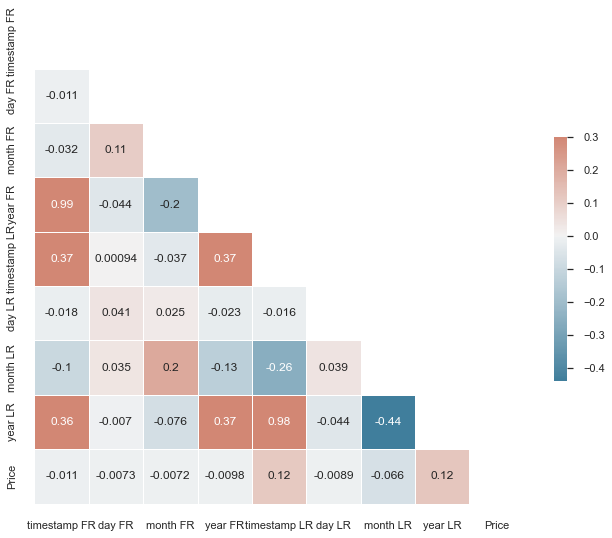

In [127]:
corr_matrix = dataset_FL_review[
    ['timestamp FR','day FR','month FR','year FR',
    'timestamp LR','day LR','month LR','year LR',"Price"]
].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

##### Analysis

In [128]:
dataset_0_reviews_f = dataset[dataset["Reviews"]==0]
na_0_reviews = dataset_0_reviews_f["First Review"].isna().sum()
print(f"Missing values for instance with no reviews: {100*na_0_reviews/dataset_0_reviews_f.shape[0]:.3f}% ({na_0_reviews}/{dataset_0_reviews_f.shape[0]})")

Missing values for instance with no reviews: 99.442% (2673/2688)


In [129]:
dataset_0_reviews_l = dataset[dataset["Reviews"]==0]
na_0_reviews = dataset_0_reviews_l["Last Review"].isna().sum()
print(f"Missing values for instance with no reviews: {100*na_0_reviews/dataset_0_reviews_l.shape[0]:.3f}% ({na_0_reviews}/{dataset_0_reviews_l.shape[0]})")

Missing values for instance with no reviews: 99.442% (2673/2688)


Unfortunately all instances corresponding to the missing values for `First Review` et `Last Review` contains missing values for all ratings features. We have three choices:  
- we do not use the ratings features
- we impute ratings features
- we delete all these instances containing missing values

In [130]:
print(dataset_0_reviews_f[~dataset_0_reviews_f["First Review"].isnull()].index)
print(dataset_0_reviews_l[~dataset_0_reviews_l["Last Review"].isnull()].index)
dataset_0_reviews_l[~dataset_0_reviews_l["Last Review"].isnull()]

Int64Index([ 1173,  2221,  2281,  2312,  2877,  3088,  6127,  6761, 10220,
            10604, 11144, 12390, 12454, 12496, 15112],
           dtype='int64')
Int64Index([ 1173,  2221,  2281,  2312,  2877,  3088,  6127,  6761, 10220,
            10604, 11144, 12390, 12454, 12496, 15112],
           dtype='int64')


,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Square Feet,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
1173,34633060.0,*,251852947.0,Hadna,2019-03-18,within an hour,90%,f,Mariendorf,Tempelhof - SchÃ¶neberg,Berlin,*,DE,Germany,52.43947,13.38664,t,Apartment,Private room,5,1.0,1.0,3.0,NaN,1,1,0,2019-05-13,2019-04-24,60.0,4.0,8.0,10.0,10.0,10.0,6.0,t,f,100.0
2221,28655172.0,*,9438722.0,Yenesa,2013-10-11,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10247.0,DE,Germany,52.51037,13.45922,t,Apartment,Entire home/apt,3,1.0,2.0,2.0,NaN,1,3,0,2019-01-26,2019-01-14,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,35.0
2281,1154769.0,*,2747111.0,Raniaa E Patrizia,2012-10-17,within an hour,100%,f,Grunewald,Charlottenburg-Wilm.,Berlin,10711.0,DE,Germany,52.49626,13.29374,t,Apartment,Entire home/apt,2,1.0,0.0,1.0,NaN,2,2,0,2015-09-30,2016-09-24,80.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,55.0
2312,8003960.0,*,32418258.0,Udri ne,2015-12-04,NaN,NaN,f,Alt-Treptow,Treptow - KÃ¶penick,Berlin,12435.0,DE,Germany,52.48881,13.44936,f,Apartment,Entire home/apt,2,1.0,1.0,2.0,NaN,1,1,0,2015-11-16,2015-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,45.0
2877,33952407.0,*,57007470.0,Sarah,2016-01-01,within a few hours,100%,f,Johannisthal,Treptow - KÃ¶penick,Berlin,*,DE,Germany,52.45918,13.57747,f,Apartment,Private room,1,1.0,1.0,0.0,NaN,1,2,0,2019-04-16,2019-05-06,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,12.0
3088,34517661.0,*,75082181.0,Saphho,2016-06-24,within an hour,100%,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10245,DE,Germany,52.51057,13.45696,t,Apartment,Entire home/apt,3,1.0,1.0,3.0,NaN,1,5,0,2019-04-05,2019-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,40.0
6127,19235314.0,*,14149424.0,Ref,2014-05-28,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10247.0,DE,Germany,52.51028,13.46004,t,Apartment,Private room,1,1.0,1.0,1.0,NaN,1,1,0,2016-01-09,2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,28.0
6761,4433058.0,*,16018173.0,Kattaina,2014-05-18,NaN,NaN,f,NeukÃ¶lln,NeukÃ¶lln,Berlin,12043.0,DE,Germany,52.47193,13.44357,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,1,0,2016-07-26,2015-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,30.0
10220,22505443.0,*,1028990.0,Rophia,2012-03-26,NaN,NaN,f,Kreuzberg,Friedrichshain-Kreuzberg,Berlin,10961.0,DE,Germany,52.48960,13.38941,f,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,3,0,2018-04-12,2018-07-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,25.0
10604,17648908.0,*,75382443.0,Amira,2016-06-16,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10245.0,DE,Germany,52.49736,13.45187,f,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,1,0,2017-08-23,2017-09-15,80.0,8.0,8.0,10.0,10.0,8.0,8.0,f,f,14.0


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Year of last review could be used whereas all other features related to last and first reviews are useless.
</div>

<a href="#top">back to top</a>

#### Ratings

- Overall Rating
- Accuracy Rating
- Cleanliness Rating
- Checkin Rating
- Communication Rating
- Location Rating
- Value Rating

##### Missing values

In [131]:
ratings = ["Overall Rating", "Accuracy Rating", "Cleanliness Rating",
           "Checkin Rating", "Communication Rating", "Location Rating",
           "Value Rating"]
for r in ratings:
    missing_values_rate_display(r, dataset)
    print()

Missing value for Overall Rating columns: 18.876% (2962/15692)
Star value for Overall Rating columns: 0.000% (0/15692)

Missing value for Accuracy Rating columns: 18.933% (2971/15692)
Star value for Accuracy Rating columns: 0.000% (0/15692)

Missing value for Cleanliness Rating columns: 18.927% (2970/15692)
Star value for Cleanliness Rating columns: 0.000% (0/15692)

Missing value for Checkin Rating columns: 18.946% (2973/15692)
Star value for Checkin Rating columns: 0.000% (0/15692)

Missing value for Communication Rating columns: 18.927% (2970/15692)
Star value for Communication Rating columns: 0.000% (0/15692)

Missing value for Location Rating columns: 18.933% (2971/15692)
Star value for Location Rating columns: 0.000% (0/15692)

Missing value for Value Rating columns: 18.940% (2972/15692)
Star value for Value Rating columns: 0.000% (0/15692)



In [132]:
dataset_ratings = dataset[ratings+["Price"]]
dataset_ratings_without_na = dataset_ratings.dropna()
missing_values = dataset_ratings.shape[0] - dataset_ratings_without_na.shape[0]
print(f"Missing value for all ratings columns: {100*missing_values/dataset.shape[0]:.3f}% ({missing_values}/{dataset.shape[0]})")

Missing value for all ratings columns: 18.965% (2976/15692)


##### Analysis

In [133]:
dataset_with_rating_na = dataset.iloc[sorted(set(range(dataset.shape[0])).difference(set(dataset_ratings_without_na.index))),:]
dataset_with_rating_non_na = dataset.iloc[dataset_ratings_without_na.index,:]

We can notice that all ratings have the same proportion of missing values. We should study all ratings together.

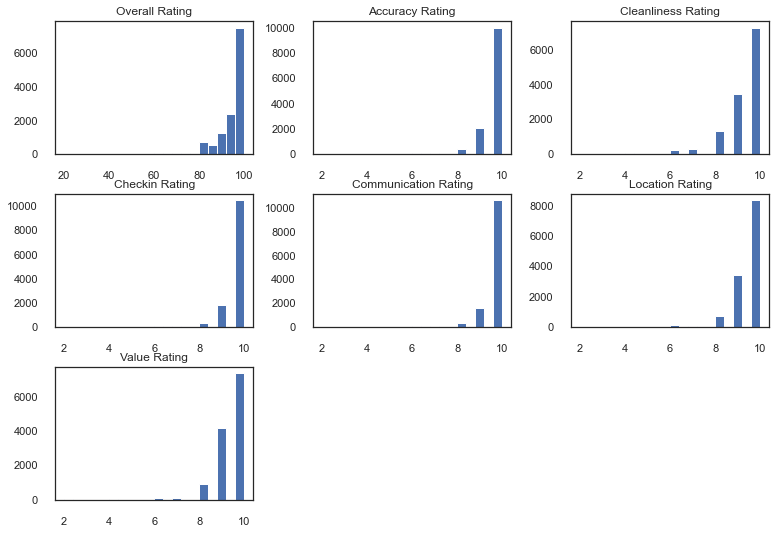

In [134]:
dataset_ratings_without_na.drop("Price",axis=1).hist(grid=False, bins=20)
plt.grid(False)
plt.show()

##### Correlation

In [135]:
corr_matrix = dataset[["Overall Rating", "Accuracy Rating", "Cleanliness Rating",
           "Checkin Rating", "Communication Rating", "Location Rating",
           "Value Rating","Price"]].corr()
corr_matrix["Price"].sort_values(ascending=False)

Price                   1.000000
Location Rating         0.076058
Cleanliness Rating      0.072634
Overall Rating          0.043537
Communication Rating    0.028882
Accuracy Rating         0.022770
Checkin Rating          0.014200
Value Rating           -0.057623
Name: Price, dtype: float64

<a href="#top">back to top</a>

<div class="alert alert-block alert-success">
<b>Conlusion:</b> We could use: Cleanliness, Location although their corelations with Price remain low.
</div>

#### Instant Bookable

##### Missing values

In [136]:
missing_values_rate_display("Instant Bookable", dataset)

Missing value for Instant Bookable columns: 0.000% (0/15692)
Star value for Instant Bookable columns: 0.000% (0/15692)


##### Categorical Values Encoding

In [137]:
dataset_IB = dataset[["Instant Bookable", "Price"]].copy()

In [138]:
dataset_IB.head()

,Instant Bookable,Price
0,t,26.0
1,f,41.0
2,f,50.0
3,f,50.0
4,t,55.0


In [139]:
dataset_IB["Instant Bookable"] = dataset_IB["Instant Bookable"].replace('t', 1)
dataset_IB["Instant Bookable"] = dataset_IB["Instant Bookable"].replace('f', 0)

##### Analysis

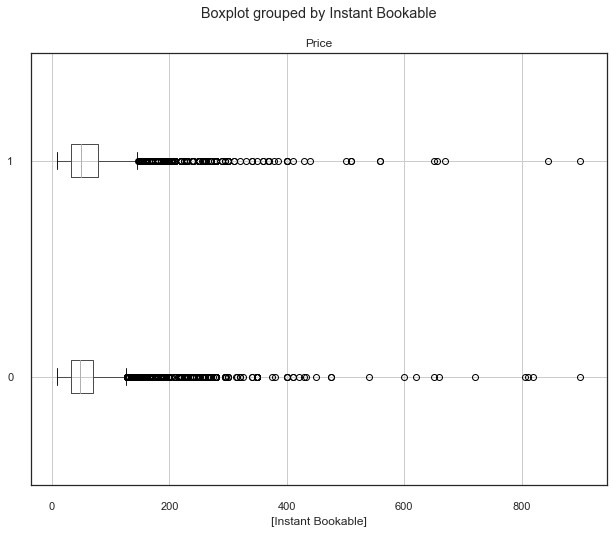

In [140]:
dataset_IB[["Instant Bookable",'Price']].boxplot(by = 'Instant Bookable', figsize=(10, 8), vert=False)
plt.show()

In [141]:
dataset_IB.pivot_table(
    index=["Instant Bookable"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Instant Bookable,,,,
0,8.0,900.0,58.975220,48.0
1,8.0,900.0,63.075894,50.0
All,8.0,900.0,60.342983,49.0


##### Correlation

In [142]:
dataset_IB.corr()

,Instant Bookable,Price
Instant Bookable,1.000000,0.039596
Price,0.039596,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> No correlation.
</div>

<a href="#top">back to top</a>

<a name="target_analysis">

### Target analysis

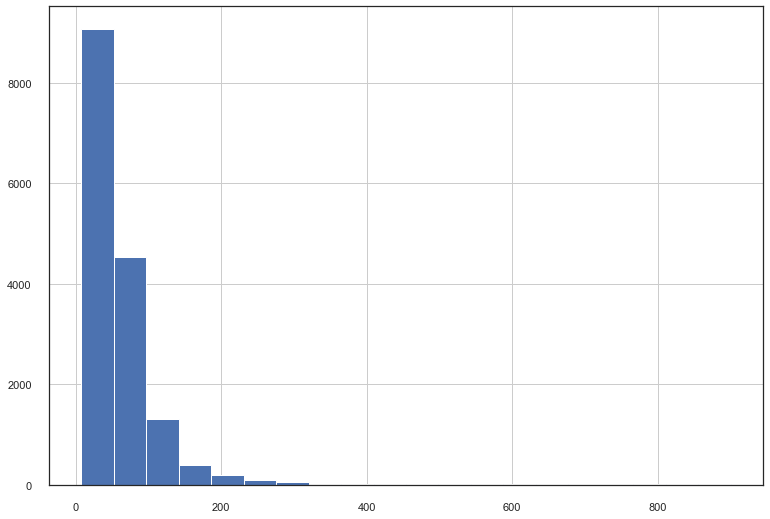

In [143]:
dataset.Price.hist(bins=20)
plt.show()

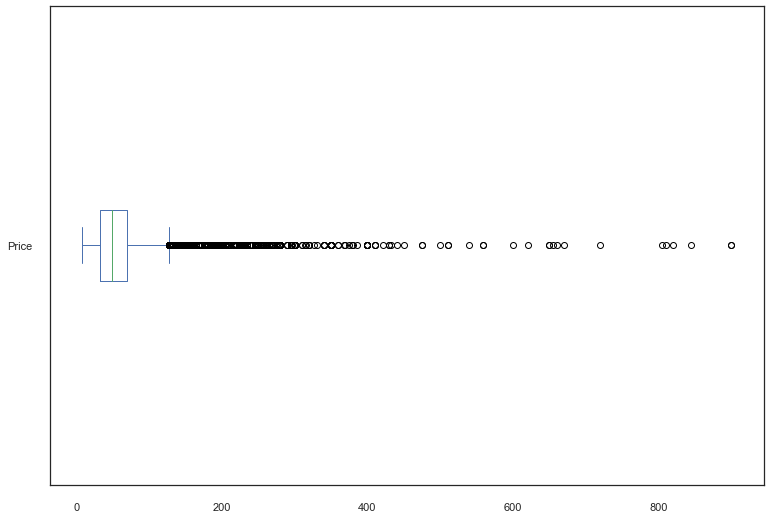

In [144]:
dataset.Price.plot.box(vert=False)
plt.show()

In [145]:
print("Price",
      f"Mean: {dataset.Price.mean():.2f}",
      f"Median: {dataset.Price.median()}",
      f"Min: {dataset.Price.min()}",
      f"Max: {dataset.Price.max()}",
      sep='\n'
     )

Price
Mean: 60.34
Median: 49.0
Min: 8.0
Max: 900.0


<a href="#top">back to top</a>

<a name="pca">

### PCA

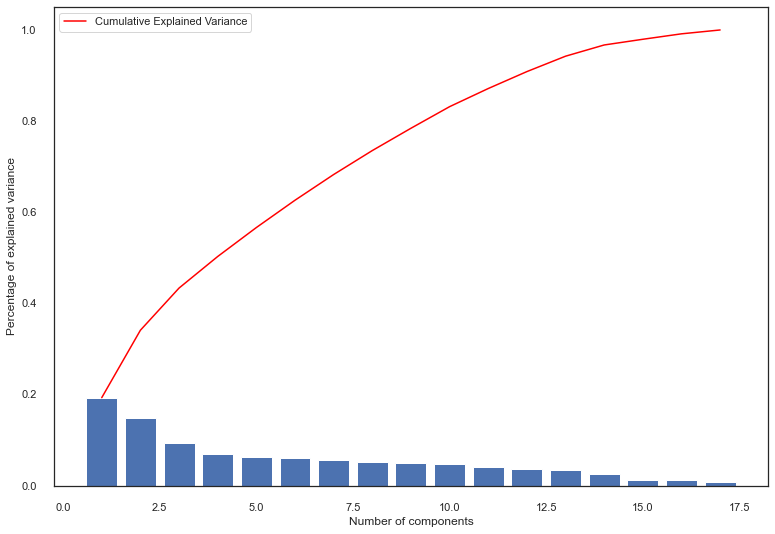

In [147]:
feature_names_pca = ["Is Superhost","neighbourhood","Property Type","Room Type","Accomodates","Bathrooms",
                     "Bedrooms","Beds","Guests Included","Reviews","Last Review","Latitude","Longitude",
                     "Neighborhood Group", "Host Since", "Instant Bookable", "Postal Code"]
dataset_select_pca = dataset.copy()
dataset_select_pca = dataset_select_pca[feature_names_pca+["Price"]]

dataset_pca_without_na = dataset_select_pca.copy()
dataset_pca_without_na.dropna(subset="Price", inplace=True)
dataset_pca_without_na.reset_index(inplace=True, drop=True)

dataset_pca_without_na["Last Review"].replace(np.NaN, "01-01-01", inplace=True) # We try imputation
dataset_pca_without_na["Host Since"].replace(np.NaN, "01-01-01", inplace=True) # We try imputation
dataset_pca_without_na = dataset_pca_without_na.dropna()
for col in dataset_pca_without_na.columns:
    dataset_pca_without_na[col] = dataset_pca_without_na[dataset_pca_without_na[col]!="*"][col]
    dataset_pca_without_na = dataset_pca_without_na[~dataset_pca_without_na[col].isna()]
    
X_pca = dataset_pca_without_na.drop("Price", axis=1)
y_pca = dataset_pca_without_na["Price"]

X_encoded_pca = X_pca.copy()

features_float_enc_pca = ["Accomodates","Bathrooms","Bedrooms","Beds","Guests Included"]
features_ordinal_enc_pca = ["Is Superhost","Room Type","Instant Bookable"] # one hot
features_LOO_enc_pca = ["neighbourhood","Property Type","Neighborhood Group","Postal Code"]


X_encoded_pca[features_float_enc_pca] = X_pca.astype({col:float for col in features_float_enc_pca})[features_float_enc_pca]

ordinal_encoder = OrdinalEncoder()
X_encoded_pca[features_ordinal_enc_pca] = ordinal_encoder.fit_transform(X_pca[features_ordinal_enc_pca])

for col in features_LOO_enc_pca:
    loo_encoder = ce.LeaveOneOutEncoder(cols=[col])
    loo_encoder.fit(X_pca[col], y_pca)
    X_encoded_pca[col] = loo_encoder.transform(X_pca[col])

X_encoded_pca['Last Review'] = pd.to_datetime(X_pca['Last Review']).dt.year.values
X_encoded_pca["Host Since"] = pd.to_datetime(X_pca["Host Since"]).dt.year.values

X_scaled_pca = X_encoded_pca.copy()

standard_scaler = StandardScaler()
X_scaled_pca = standard_scaler.fit_transform(X_scaled_pca)

pca = PCA()
pca_out = PCA().fit(X_scaled_pca, y_pca)
X_new_scaled_pca = pca.fit_transform(X_scaled_pca)[:,:4]

# Explained variance plot
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_ ),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

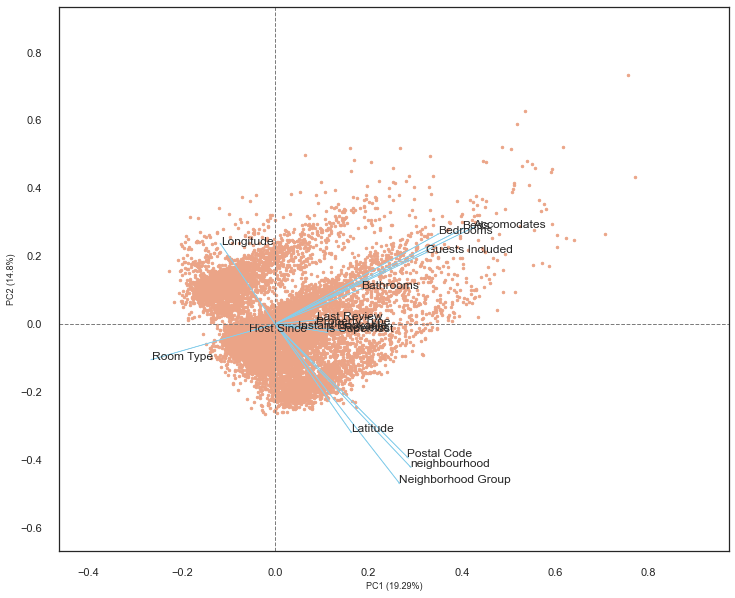

In [148]:
# get 2D biplot
cluster.biplot(cscore=X_new_scaled_pca[:,:2], loadings=pca.components_[:2, :], 
               labels=X_encoded_pca.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2), r=1000, dim=(12,10), show=True)

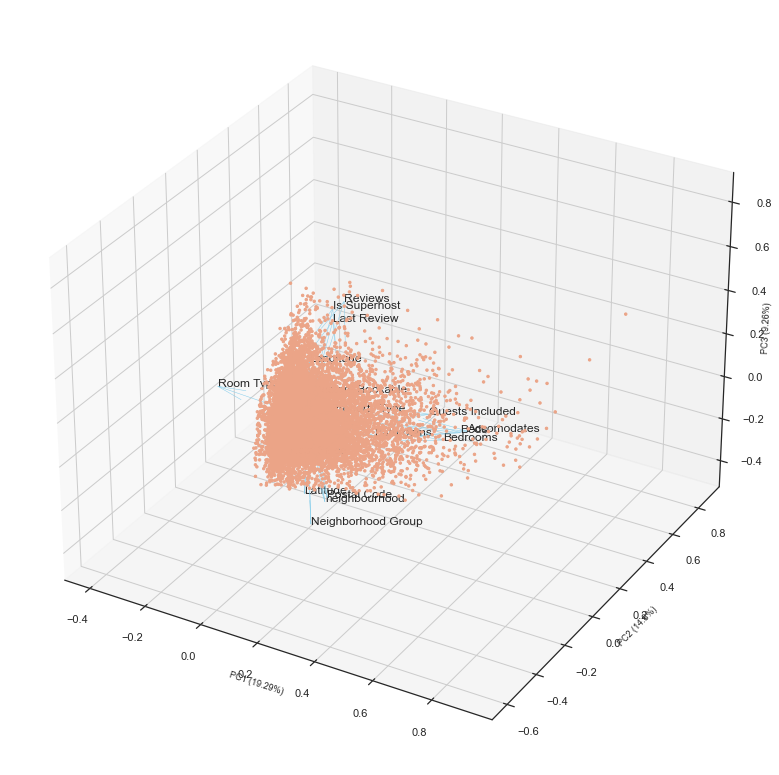

In [149]:
cluster.biplot(cscore=X_new_scaled_pca[:,:3], loadings=pca.components_[:3, :], labels=X_encoded_pca.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2), r=1000, dim=(16,14), show=True)

<a href="#top">back to top</a>

<a name="conclusion">

### Conclusion

We create 3 categories for our features:
<ul>
    <li>
        <b>Features with a good correlation to the rental price that will be used for our model:</b>
        <ul>
            <li><font color='green'>Is Superhost</font></li>
            <li><font color='green'>neighbourhood</font></li>
            <li><font color='green'>Property Type</font></li>
            <li><font color='green'>Room Type</font></li>
            <li><font color='green'>Accomodates</font></li>
            <li><font color='green'>Bathrooms</font></li>
            <li><font color='green'>Bedrooms</font></li>
            <li><font color='green'>Beds</font></li>
            <li><font color='green'>Guests Included</font></li>
            <li><font color='green'>Reviews</font></li>
            <li><font color='green'>Last Review (year)</font></li>
            <li><font color='green'>Cleanliness Rating</font></li>
            <li><font color='green'>Location Rating</font></li>
            <li><font color='green'>Value Rating</font></li>
        </ul>
    </li>
    <li>
        <b>Features with a low correlation to the rental price or feature that create data redundancy:</b>
        <ul>
            <li><font color='orange'>Host since</font> (too low correlations + too much missing values)</li>
            <li><font color='orange'>Host Response Rate</font> (too low correlations)</li>
            <li><font color='orange'>Neighborhood Group</font> (redundancy with neighbourhood)</li>
            <li><font color='orange'>Postal Code</font> (redundancy with neighbourhood)</li>
            <li><font color='orange'>Latitude et Longitude</font> (redundancy with neighbourhood)</li>
            <li><font color='orange'>Instant Bookable </font> (too low correlations)</li>
            <li><font color='orange'>First Review </font> (too low correlations)</li>
            <li><font color='orange'>Overall Rating </font> (too low correlations)</li>
            <li><font color='orange'>Accuracy Rating </font> (too low correlations)</li>
            <li><font color='orange'>Communication Rating </font> (too low correlations)</li>
        </ul>
    </li>
    <li>
        <b>Features that can't be used:</b>
        <ul>
            <li><font color='red'>Host Name</font> (no exploitable informations)</li>
            <li><font color='red'>Host ID</font> (no exploitable informations)</li>
            <li><font color='red'>Listing Name</font> (no exploitable informations)</li>
            <li><font color='red'>Listing ID</font> (no exploitable informations)</li>
            <li><font color='red'>Postal Code</font> (redundancy)</li>
            <li><font color='red'>Country Code</font> (only one value)</li>
            <li><font color='red'>Country</font> (only one value)</li>
            <li><font color='red'>City</font> (only one value)</li>
            <li><font color='red'>Business Travel Ready</font> (only one value)</li>
            <li><font color='red'>square_feet</font> (too much missing values)</li>
            <li><font color='red'>Is Exact Location </font> (no correlations)</li>
            <li><font color='red'>Min Nights </font> (no correlations)</li>
            <li><font color='red'>Checkin Rating </font> (no correlations)</li>
        </ul>
    </li>
</ul>


<a href="#top">back to top</a>

<a name="preprocessing">

## Preprocessing
---

<a name="feat_selec">

### Feature selection

We choose the following features:

In [150]:
feature_names = ["Is Superhost","neighbourhood","Property Type","Room Type","Accomodates","Bathrooms",
                 "Bedrooms","Beds","Guests Included","Reviews","Last Review"]
dataset_select = dataset.copy()
dataset_select = dataset_select[feature_names+["Price"]]

<div class="alert alert-block alert-info">
<b>Rq:</b> We tried with all the ratings but the performance was worst</div>

<a href="#top">back to top</a>

<a name="missing_values">

### Missing values (NaN et *)

**Target (Price):** There are only 9 missing values for the target, so we will drop them

In [151]:
dataset_without_na = dataset_select.copy()
dataset_without_na.dropna(subset="Price", inplace=True)
dataset_without_na.reset_index(inplace=True, drop=True)

**Features**

In [152]:
dataset_without_na["Last Review"].replace(np.NaN, "01-01-01", inplace=True) # We try imputation
dataset_without_na = dataset_without_na.dropna()
for col in dataset_without_na.columns:
    dataset_without_na[col] = dataset_without_na[dataset_without_na[col]!="*"][col]
    dataset_without_na = dataset_without_na[~dataset_without_na[col].isna()]
dataset_without_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15322 entries, 0 to 15682
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Is Superhost     15322 non-null  object 
 1   neighbourhood    15322 non-null  object 
 2   Property Type    15322 non-null  object 
 3   Room Type        15322 non-null  object 
 4   Accomodates      15322 non-null  object 
 5   Bathrooms        15322 non-null  object 
 6   Bedrooms         15322 non-null  object 
 7   Beds             15322 non-null  object 
 8   Guests Included  15322 non-null  object 
 9   Reviews          15322 non-null  int64  
 10  Last Review      15322 non-null  object 
 11  Price            15322 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 1.5+ MB


<a href="#top">back to top</a>

<a name="split">

### Split

In [196]:
X = dataset_without_na.drop("Price", axis=1)
y = dataset_without_na["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
print(X_train.shape,y_train.shape)

(10725, 11) (10725,)


<a href="#split_ana">Go to analysis of split</a>

<a href="#top">back to top</a>

<a name="cat_feat">

### Categorical features

Tests effectués :
- Ordinal/OneHotEncoding (avec seulement la colonne Entire Home) pour Room Type
- 

In [219]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

features_float_enc = ["Accomodates", "Bathrooms", "Bedrooms", "Beds", "Guests Included"]
features_ordinal_enc = ["Is Superhost"]
features_LOO_enc = ["neighbourhood", "Property Type"]

X_train_encoded[features_float_enc] = X_train.astype({col:float for col in features_float_enc})[features_float_enc]
X_test_encoded[features_float_enc] = X_test.astype({col:float for col in features_float_enc})[features_float_enc]

ordinal_encoder = OrdinalEncoder()
X_train_encoded[features_ordinal_enc] = ordinal_encoder.fit_transform(X_train[features_ordinal_enc])
X_test_encoded[features_ordinal_enc] = ordinal_encoder.transform(X_test[features_ordinal_enc])

for col in features_LOO_enc:
    loo_encoder = ce.LeaveOneOutEncoder(cols=[col], sigma=0.1)
    loo_encoder.fit(X_train[col], y_train)
    X_train_encoded[col] = loo_encoder.transform(X_train[col])
    X_test_encoded[col] = loo_encoder.transform(X_test[col])

X_train_encoded["Room Type"] = pd.get_dummies(X_train["Room Type"])["Entire home/apt"]    
X_test_encoded["Room Type"] = pd.get_dummies(X_test["Room Type"])["Entire home/apt"]    

X_train_encoded['Last Review'] = pd.to_datetime(X_train['Last Review']).dt.year.values
X_test_encoded['Last Review'] = pd.to_datetime(X_test['Last Review']).dt.year.values

<a href="#top">back to top</a>

<a name="scaling">

### Scaling

In [220]:
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

standard_scaler = StandardScaler()

features_to_scale_norm = X_train_scaled.columns
X_train_scaled[features_to_scale_norm] = standard_scaler.fit_transform(X_train_encoded[features_to_scale_norm])
X_test_scaled[features_to_scale_norm] = standard_scaler.transform(X_test_encoded[features_to_scale_norm])

<a href="#top">back to top</a>

<a name="feature_eng">

### Feature engineering

We will create the following features:
<ul>
  <li>Total  Number of rooms</li>
  <li>Average no of beds/room</li>
  <li>Distance to center of Berlin</li>
</ul>

In [221]:
X_train_feature_eng = X_train_encoded.copy()
X_test_feature_eng = X_test_encoded.copy()

In [222]:
X_train_feature_eng.head()

,Is Superhost,neighbourhood,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Guests Included,Reviews,Last Review
12177,0.0,61.991635,57.984894,1,2.0,1.0,2.0,1.0,1.0,0,2001
5100,0.0,68.462687,57.984894,1,4.0,1.0,2.0,2.0,2.0,8,2016
6032,0.0,61.991635,57.984894,1,2.0,1.0,1.0,1.0,2.0,19,2016
5513,1.0,59.722488,49.758621,0,2.0,1.0,1.0,1.0,1.0,53,2019
3869,0.0,57.525424,57.984894,0,2.0,1.0,1.0,1.0,1.0,0,2001


##### Total Number of Rooms


In [223]:
X_train_feature_eng["Total Rooms"] = X_train_feature_eng["Bedrooms"] + X_train_feature_eng["Bathrooms"]
X_test_feature_eng["Total Rooms"] = X_test_feature_eng["Bedrooms"] + X_test_feature_eng["Bathrooms"]

In [224]:
corr_tab = X_train_feature_eng.copy()
corr_tab = pd.concat((corr_tab, y_train.copy()), axis=1)
corr_tab[["Total Rooms","Price"]].corr()["Price"].sort_values(ascending = False)

Price          1.000000
Total Rooms    0.428581
Name: Price, dtype: float64

<div class="alert alert-block alert-info">
<b>Rq:</b> The correlation is very good, we could test the models with this features and removing bathrooms and bedrooms.</div>

##### Average No of Beds per Bedrooms

In [225]:
X_train_feature_eng["Avg Beds"] = X_train_feature_eng["Beds"] / X_train_feature_eng["Bedrooms"]
X_test_feature_eng["Avg Beds"] = X_test_feature_eng["Beds"] / X_test_feature_eng["Bedrooms"]
X_train_feature_eng["Avg Beds"] = X_train_feature_eng["Avg Beds"].replace([np.NaN,np.inf],[0,0])
X_test_feature_eng["Avg Beds"] = X_test_feature_eng["Avg Beds"].replace([np.NaN,np.inf],[0,0])

In [226]:
corr_tab = X_train_feature_eng.copy()
corr_tab = pd.concat((corr_tab, y_train.copy()), axis=1)
corr_tab[["Avg Beds","Price"]].corr()["Price"].sort_values(ascending = False)

Price       1.000000
Avg Beds    0.126908
Name: Price, dtype: float64

##### Distance to center

In [227]:
coordonnees = dataset[["Latitude", "Longitude","Price"]].copy()

In [228]:
coordonnees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15692 entries, 0 to 15691
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   15692 non-null  float64
 1   Longitude  15692 non-null  float64
 2   Price      15683 non-null  float64
dtypes: float64(3)
memory usage: 367.9 KB


In [229]:
coord_berlin = [52.520008, 13.404954]
lat1 = 52.520008
lon1 = 13.404954

In [230]:
coordonnees["Distance"] = np.sin(lat1)*np.sin(coordonnees["Latitude"])+np.cos(lat1)*np.cos(coordonnees["Latitude"])*np.cos(coordonnees["Longitude"]-lon1)

In [231]:
coordonnees.head()

,Latitude,Longitude,Price,Distance
0,52.54652,13.41792,26.0,0.999614
1,52.56512,13.42214,41.0,0.998920
2,52.54741,13.42521,50.0,0.999540
3,52.50958,13.45144,50.0,0.999520
4,52.52995,13.41558,55.0,0.999928


In [232]:
coordonnees.corr()["Price"].sort_values(ascending = False)

Price        1.000000
Distance     0.051555
Latitude     0.039158
Longitude   -0.041581
Name: Price, dtype: float64

<a href="#top">back to top</a>

<a name="split_ana">

### Split analysis

#### Target

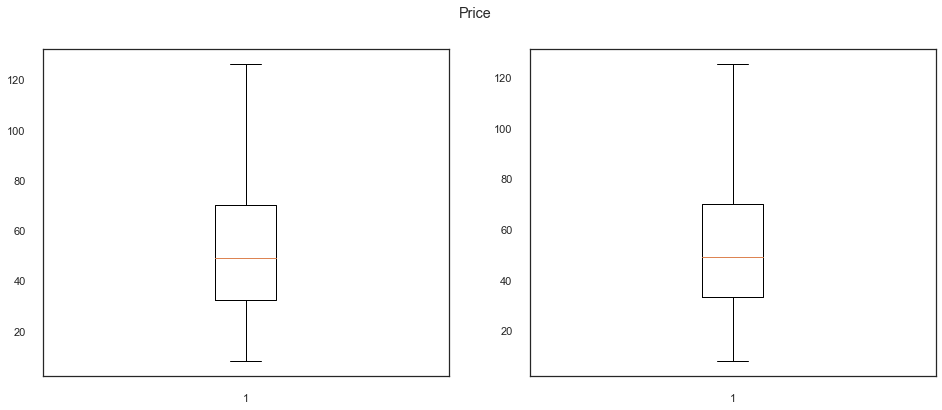

In [260]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].boxplot(y_train,showfliers = False)
axes[1].boxplot(y_test,showfliers = False)
plt.suptitle("Price")
plt.show()

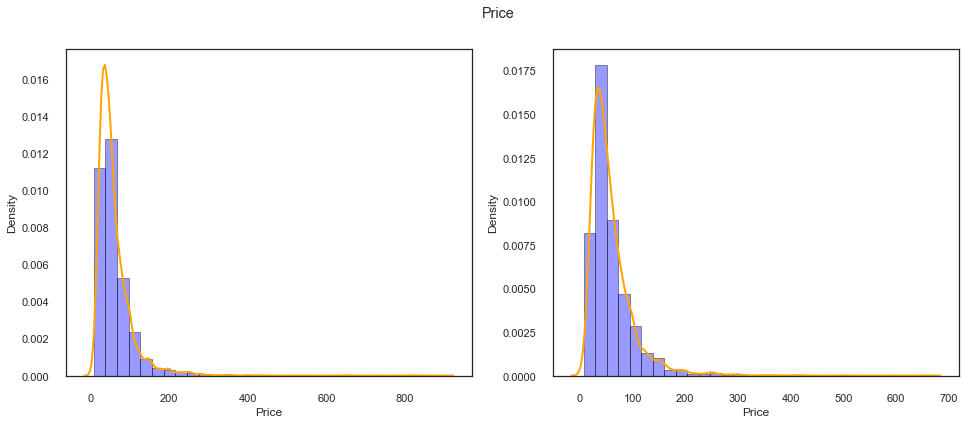

In [249]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
sns.distplot(y_train, hist=True, kde=True, 
             bins=30, color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, 'color':'orange'}, ax=axes[0])
sns.distplot(y_test, hist=True, kde=True, 
             bins=30, color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, 'color':'orange'}, ax=axes[1])
plt.suptitle("Price")
plt.show()

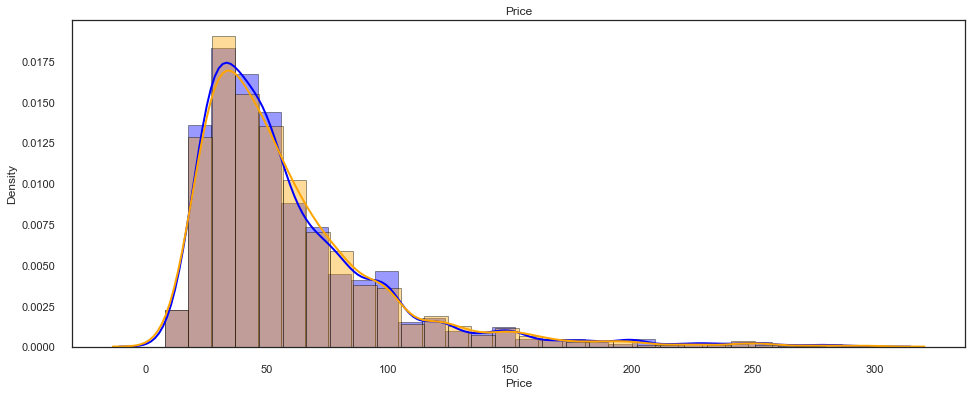

In [156]:
fig, ax = plt.subplots(figsize=(16,6))
sns.distplot(y_train[y_train<300], hist=True, kde=True, 
             bins=30, color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, 'color':'blue'}, ax=ax)
sns.distplot(y_test[y_test<300], hist=True, kde=True, 
             bins=30, color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, 'color':'orange'}, ax=ax)
plt.title("Price")
plt.show()

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.2305>0.05) so we cannot reject the null hypothesis


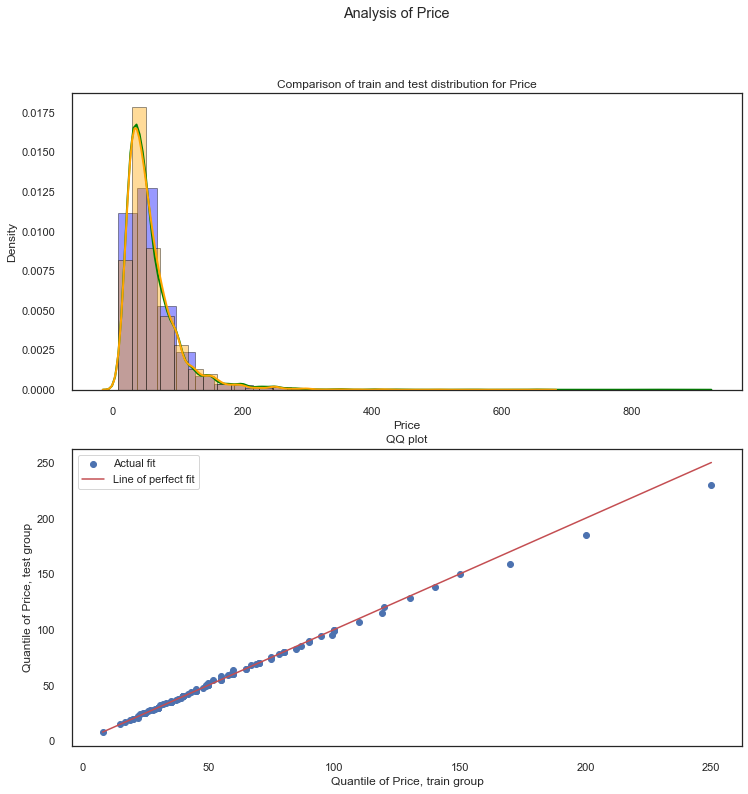

In [292]:
compare_continuous_distribution((y_train, y_test))

In [157]:
test_distribution(y_train, y_test)

Same distribution (KStest): pvalue>alpha (0.3651>0.05) so we cannot reject the null hypothesis


#### Features

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.4073>0.05) so we cannot reject the null hypothesis


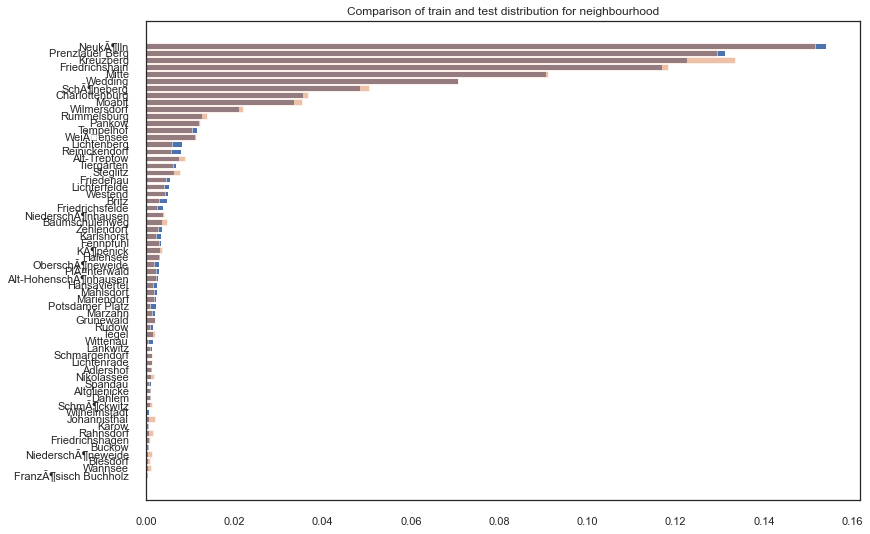

In [268]:
compare_discrete_distribution((X_train,X_test), "neighbourhood", 
                              (X_train_encoded, X_test_encoded))

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.2358>0.05) so we cannot reject the null hypothesis


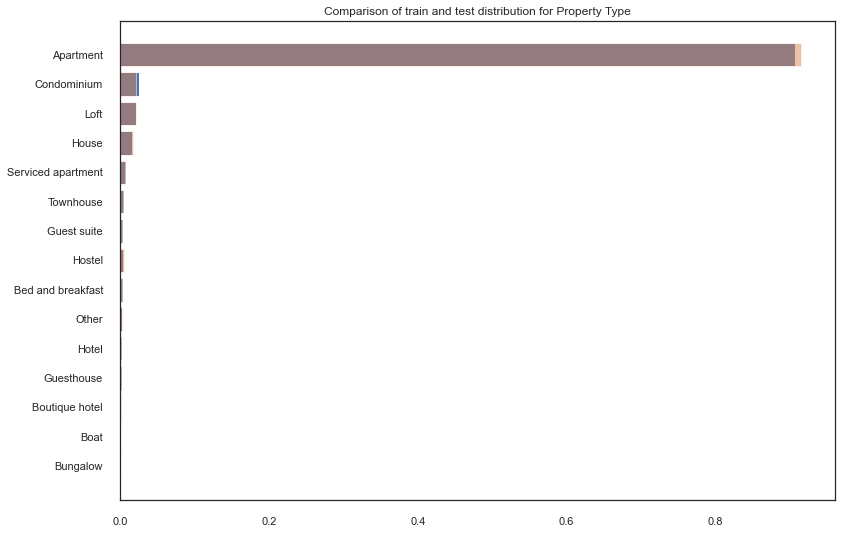

In [269]:
compare_discrete_distribution((X_train, X_test), 'Property Type', 
                              (X_train_encoded, X_test_encoded))

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.0922>0.05) so we cannot reject the null hypothesis


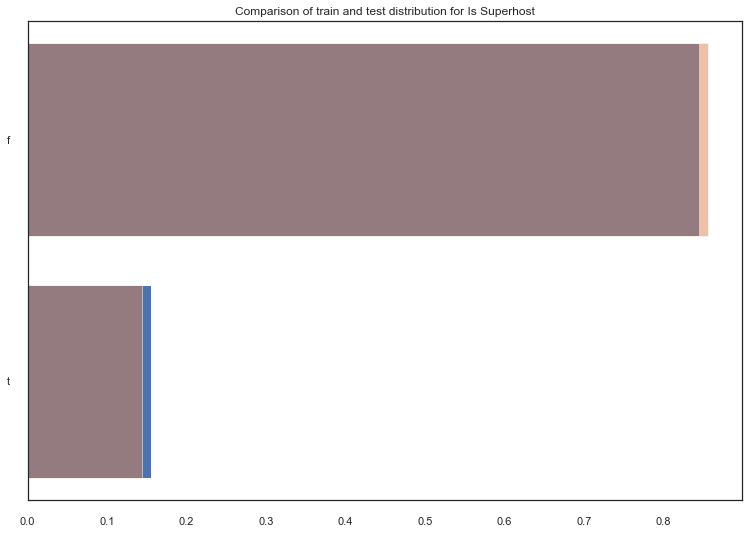

In [270]:
compare_discrete_distribution((X_train, X_test), 'Is Superhost', 
                              (X_train_encoded, X_test_encoded))

Same distribution (KStest): pvalue>alpha (1.0>0.05) so we cannot reject the null hypothesis


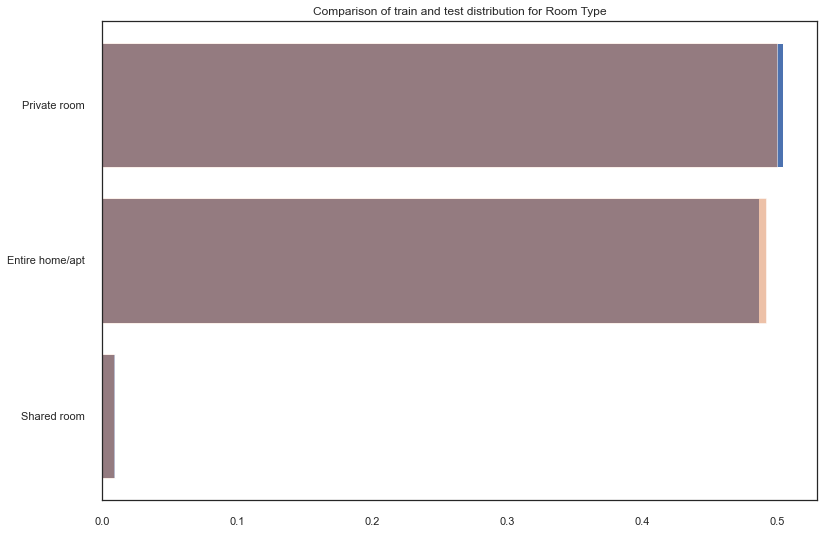

In [161]:
compare_discrete_distribution(X_train, X_test, 'Room Type')

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.8634>0.05) so we cannot reject the null hypothesis


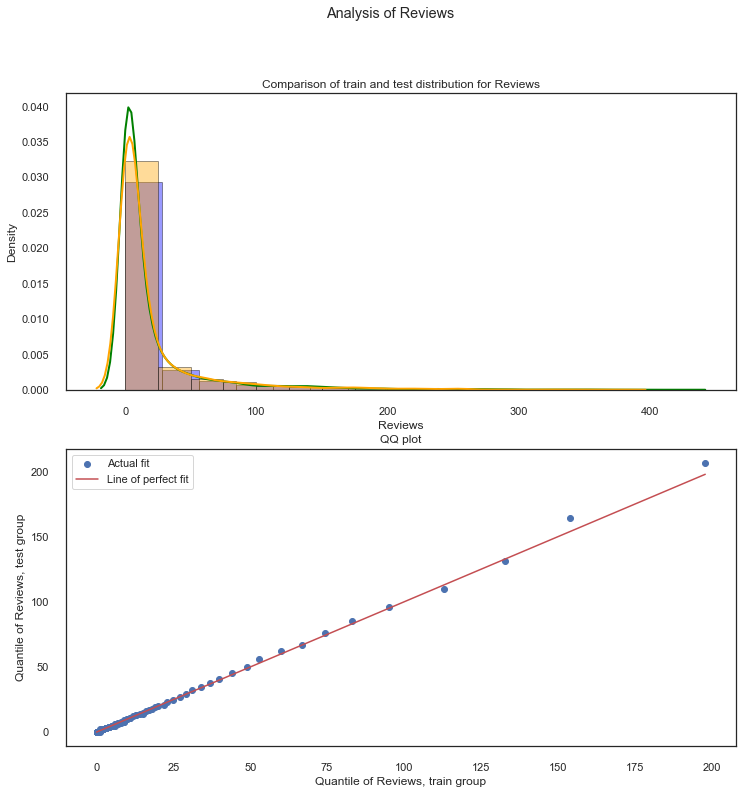

In [271]:
compare_continuous_distribution((X_train, X_test), 'Reviews',
                                (X_train_encoded, X_test_encoded),bins=15)

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.8741>0.05) so we cannot reject the null hypothesis


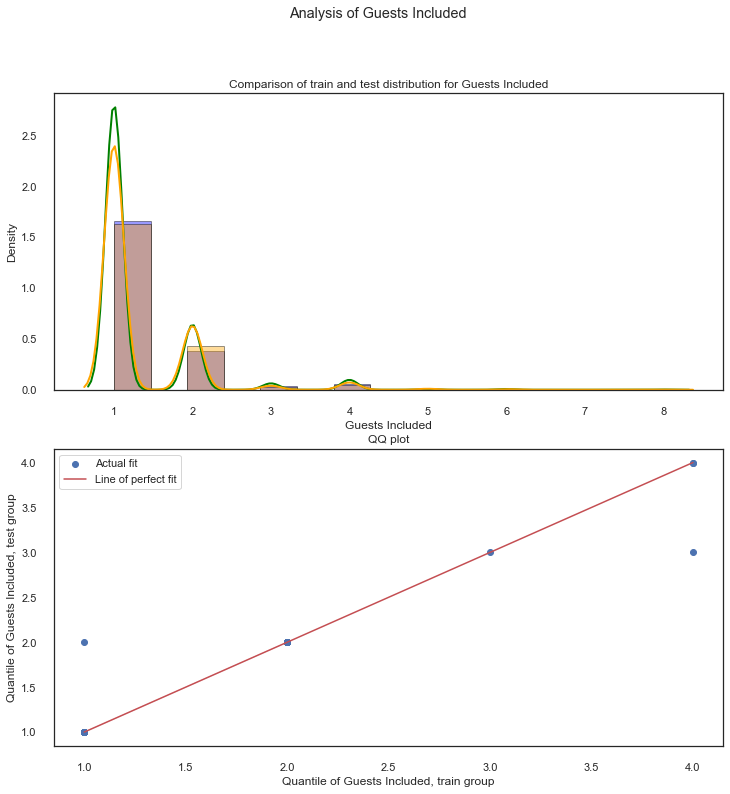

In [274]:
compare_continuous_distribution((X_train, X_test), "Guests Included", 
                                (X_train_encoded, X_test_encoded), bins=15)

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.2084>0.05) so we cannot reject the null hypothesis


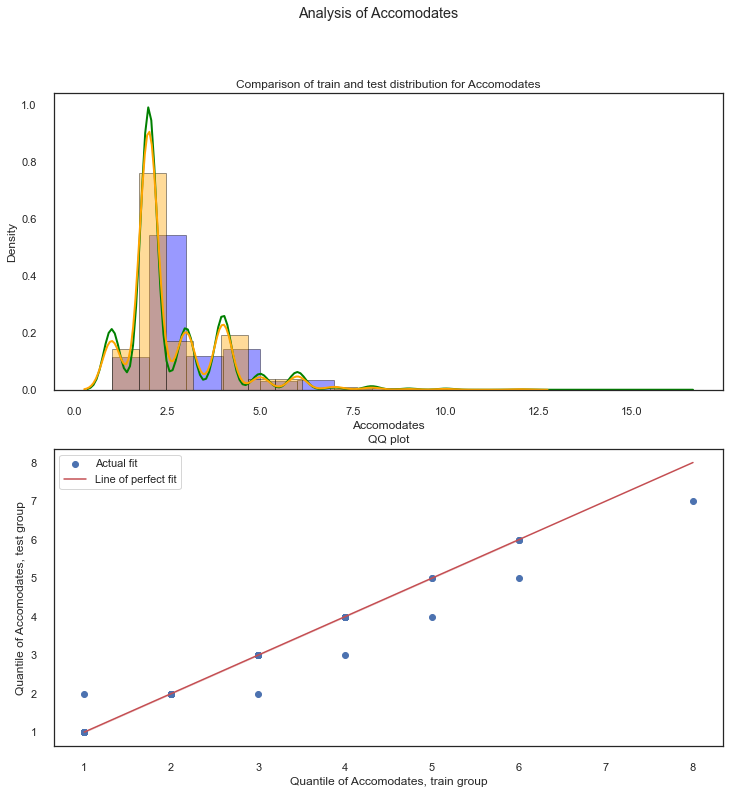

In [275]:
compare_continuous_distribution((X_train, X_test), 'Accomodates', 
                                (X_train_encoded, X_test_encoded), bins=15)

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.1868>0.05) so we cannot reject the null hypothesis


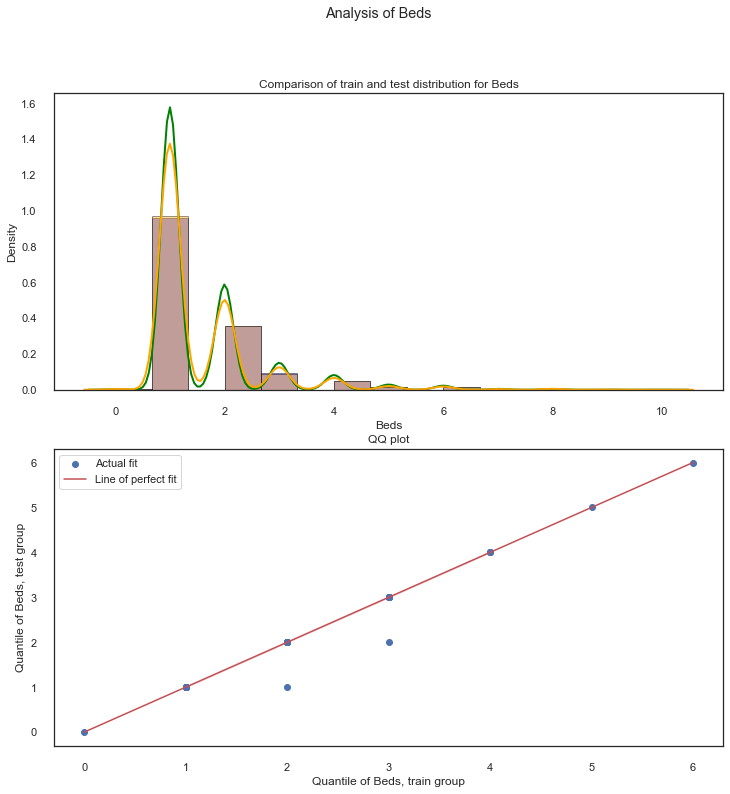

In [276]:
compare_continuous_distribution((X_train, X_test), 'Beds', 
                                (X_train_encoded, X_test_encoded), bins=15)

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.9317>0.05) so we cannot reject the null hypothesis


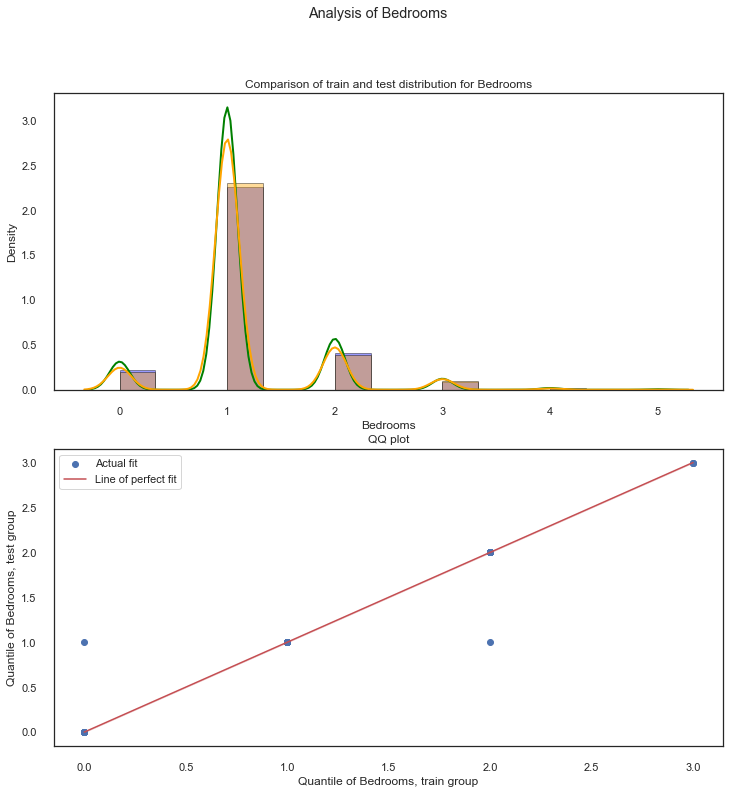

In [277]:
compare_continuous_distribution((X_train, X_test), 'Bedrooms', 
                                (X_train_encoded, X_test_encoded), bins=15)

Student T-test: test differences in means (global)
Same distribution: pvalue>alpha (0.9083>0.05) so we cannot reject the null hypothesis


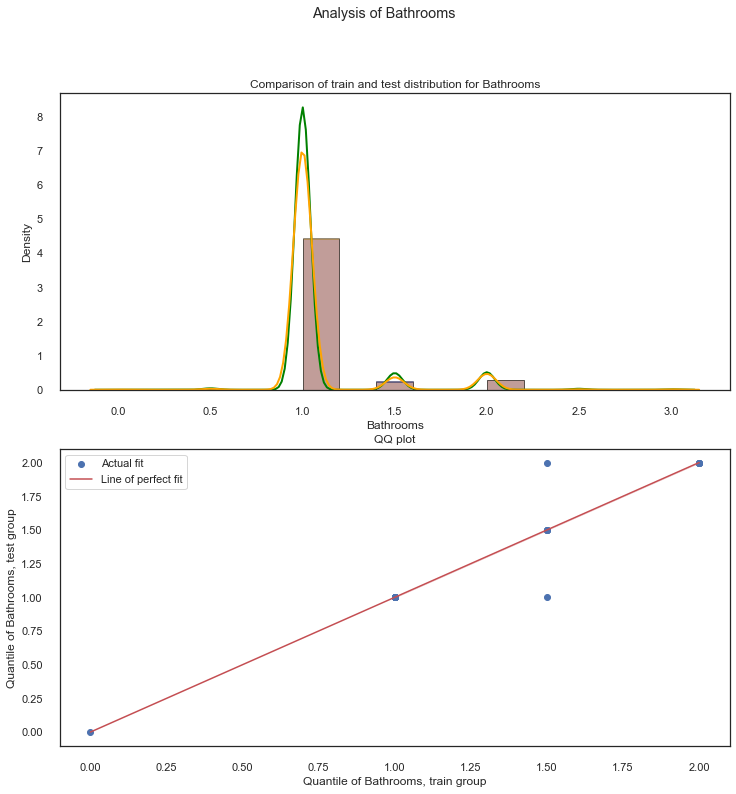

In [278]:
compare_continuous_distribution((X_train, X_test), 'Bathrooms', 
                                (X_train_encoded, X_test_encoded), bins=15)

<a href="#top">back to top</a>

<a name="pca_prep">

### PCA

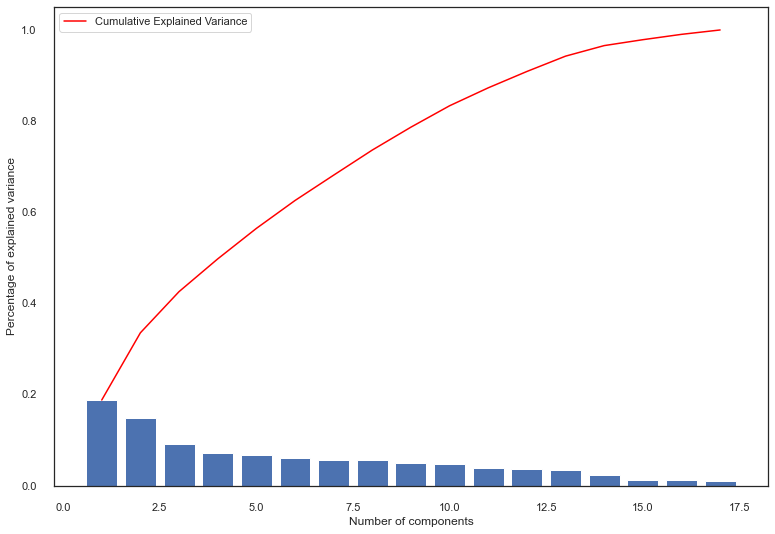

In [233]:
feature_names_pca = ["Is Superhost","neighbourhood","Property Type","Room Type","Accomodates","Bathrooms",
                     "Bedrooms","Beds","Guests Included","Reviews","Last Review","Latitude","Longitude",
                     "Neighborhood Group", "Host Since", "Instant Bookable", "Postal Code"]
dataset_select_pca = dataset.copy()
dataset_select_pca = dataset_select_pca[feature_names_pca+["Price"]]

dataset_pca_without_na = dataset_select_pca.copy()
dataset_pca_without_na.dropna(subset="Price", inplace=True)
dataset_pca_without_na.reset_index(inplace=True, drop=True)

dataset_pca_without_na["Last Review"].replace(np.NaN, "01-01-01", inplace=True) # We try imputation
dataset_pca_without_na["Host Since"].replace(np.NaN, "01-01-01", inplace=True) # We try imputation
dataset_pca_without_na = dataset_pca_without_na.dropna()
for col in dataset_pca_without_na.columns:
    dataset_pca_without_na[col] = dataset_pca_without_na[dataset_pca_without_na[col]!="*"][col]
    dataset_pca_without_na = dataset_pca_without_na[~dataset_pca_without_na[col].isna()]
    
X_pca = dataset_pca_without_na.drop("Price", axis=1)
y_pca = dataset_pca_without_na["Price"]
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, train_size=0.7, random_state=0)

X_train_encoded_pca = X_train_pca.copy()
X_test_encoded_pca = X_test_pca.copy()

features_float_enc_pca = ["Accomodates","Bathrooms","Bedrooms","Beds","Guests Included"]
features_ordinal_enc_pca = ["Is Superhost","Room Type","Instant Bookable"] # one hot
features_LOO_enc_pca = ["neighbourhood","Property Type","Neighborhood Group","Postal Code"]


X_train_encoded_pca[features_float_enc] = X_train_pca.astype({col:float for col in features_float_enc_pca})[features_float_enc_pca]
X_test_encoded_pca[features_float_enc] = X_test_pca.astype({col:float for col in features_float_enc_pca})[features_float_enc_pca]

ordinal_encoder = OrdinalEncoder()
X_train_encoded_pca[features_ordinal_enc_pca] = ordinal_encoder.fit_transform(X_train_pca[features_ordinal_enc_pca])
X_test_encoded_pca[features_ordinal_enc_pca] = ordinal_encoder.transform(X_test_pca[features_ordinal_enc_pca])

for col in features_LOO_enc_pca:
    loo_encoder = ce.LeaveOneOutEncoder(cols=[col])
    loo_encoder.fit(X_train_pca[col], y_train_pca)
    X_train_encoded_pca[col] = loo_encoder.transform(X_train_pca[col])
    X_test_encoded_pca[col] = loo_encoder.transform(X_test_pca[col])

X_train_encoded_pca['Last Review'] = pd.to_datetime(X_train_pca['Last Review']).dt.year.values
X_test_encoded_pca['Last Review'] = pd.to_datetime(X_test_pca['Last Review']).dt.year.values
X_train_encoded_pca["Host Since"] = pd.to_datetime(X_train_pca["Host Since"]).dt.year.values
X_test_encoded_pca["Host Since"] = pd.to_datetime(X_test_pca["Host Since"]).dt.year.values


X_train_scaled_pca = X_train_encoded_pca.copy()
X_test_scaled_pca = X_test_encoded_pca.copy()

standard_scaler = StandardScaler()
X_train_scaled_pca = standard_scaler.fit_transform(X_train_scaled_pca)
X_test_scaled_pca = standard_scaler.transform(X_test_scaled_pca)

pca = PCA()
pca_out = PCA().fit(X_train_scaled_pca, y_train_pca)
X_train_pca = pca.fit_transform(X_train_scaled_pca)[:,:3]
X_test_pca = pca.fit_transform(X_test_scaled_pca)[:,:3]

# Explained variance plot
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_ ),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

<a href="#top">back to top</a>

<a name="def_dataset">

### Definitive Dataset

The features bellow are ordered by descending correlation.

Good features : 
- Accommodates
- Total Rooms (created)
- Entire home/apt (when one hot encoding)
- Beds (*)
- Bedrooms (*)
- Room Type 
- Guests Included (*)
- Bathrooms
- Neighbourhood
- Avg Beds (created)
- Property Time
- Host Since (year)

(*) Choose only one

Not good correlation, but to test:
- Is Superhost
- Reviews
- Distance (created)
- Longitude
- Latitude
- Instant Bookable
- Min Nights
- Is Exact Location

In [235]:
X_train_cleaned = X_train_encoded.copy()
X_test_cleaned = X_test_encoded.copy()

X_train_cleaned_scaled = X_train_scaled.copy()
X_test_cleaned_scaled = X_test_scaled.copy()

X_train_cleaned_feature_eng = X_train_feature_eng.drop(["Guests Included","Beds","Total Rooms"],axis=1)
X_test_cleaned_feature_eng = X_test_feature_eng.drop(["Guests Included","Beds","Total Rooms"],axis=1)

X_train_cleaned_pca = X_train_pca.copy()
X_test_cleaned_pca = X_test_pca.copy()

<a href="#top">back to top</a>

<a name="modeling">

## Modeling
---

<a name="linear">

### Linear Regression

In [187]:
rf = LinearRegression()
sfs1 = SFS(rf, 
           k_features=(1,X_train_cleaned_scaled.shape[1]), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train_cleaned_scaled, y_train)
sfs1.subsets_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished

[2022-10-28 08:51:28] Features: 1/11 -- score: -1838.6959600924936[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished

[2022-10-28 08:51:28] Features: 2/11 -- score: -1729.0561989690132[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished

[2022-10-28 08:51:28] Features: 3/11 -- score: -1665.844549515716[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

{1: {'feature_idx': (4,),
  'cv_scores': array([-1838.69596009]),
  'avg_score': -1838.6959600924936,
  'feature_names': ('Accomodates',)},
 2: {'feature_idx': (3, 4),
  'cv_scores': array([-1729.05619897]),
  'avg_score': -1729.0561989690132,
  'feature_names': ('Room Type', 'Accomodates')},
 3: {'feature_idx': (1, 3, 4),
  'cv_scores': array([-1665.84454952]),
  'avg_score': -1665.844549515716,
  'feature_names': ('neighbourhood', 'Room Type', 'Accomodates')},
 4: {'feature_idx': (1, 3, 4, 5),
  'cv_scores': array([-1614.96364089]),
  'avg_score': -1614.9636408940135,
  'feature_names': ('neighbourhood', 'Room Type', 'Accomodates', 'Bathrooms')},
 5: {'feature_idx': (1, 2, 3, 4, 5),
  'cv_scores': array([-1567.67247475]),
  'avg_score': -1567.6724747498822,
  'feature_names': ('neighbourhood',
   'Property Type',
   'Room Type',
   'Accomodates',
   'Bathrooms')},
 6: {'feature_idx': (1, 2, 3, 4, 5, 6),
  'cv_scores': array([-1538.1186441]),
  'avg_score': -1538.1186441037569,
  'fea

In [188]:
print(f"Features: {sfs1.k_feature_names_}",
      f"MSE: {-sfs1.k_score_:.2f}",
      sep="\n")

Features: ('Is Superhost', 'neighbourhood', 'Property Type', 'Room Type', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Reviews', 'Last Review')
MSE: 1522.01


LinearRegression
mse = 1029.63
mae = 20.17
r2 = 0.434
adjusted r2 = 0.434

Cross_validation (10 cv)
mse = mean:1036.54 | std:317.32
mae = mean:20.00 | std:1.03
r2 = mean:0.435 | std:0.070
adjusted r2 = mean:0.421 | std:0.071


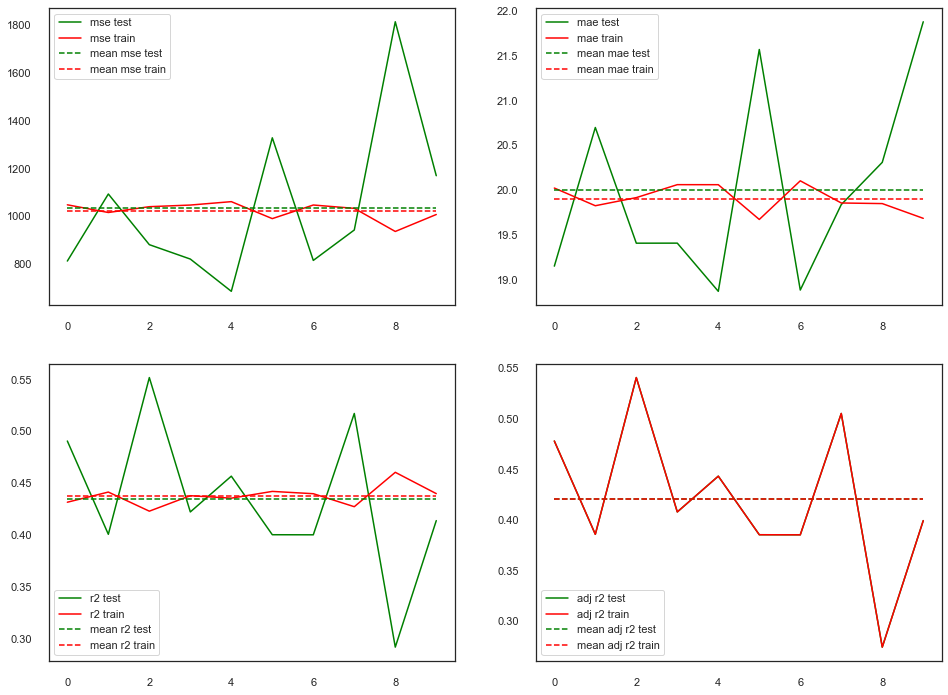

In [236]:
model = LinearRegression()
model.fit(X_train_cleaned_scaled[list(sfs1.k_feature_names_)], y_train)
score_model(model, X_test_cleaned_scaled[list(sfs1.k_feature_names_)], y_test, cross_valid=True)

#### New features dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_pca, y_train_pca)
score_model(model, X_test_cleaned_pca, y_test_pca, cross_valid=True)

<a href="#top">back to top</a>

<a name="linear">

### SVM

In [ ]:
rf = LinearRegression()
sfs1 = SFS(rf, 
           k_features=(1,X_train_cleaned.shape[1]), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train_cleaned, y_train)
sfs1.subsets_

In [ ]:
print(f"Features: {sfs1.k_feature_names_}",
      f"MSE: {-sfs1.k_score_:.2f}",
      sep="\n")

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned[list(sfs1.k_feature_names_)], y_train)
score_model(model, X_test_cleaned[list(sfs1.k_feature_names_)], y_test, cross_valid=True)

#### New features dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_pca, y_train_pca)
score_model(model, X_test_cleaned_pca, y_test_pca, cross_valid=True)

#### Original dataset

#### Scaled dataset

#### New features dataset

#### PCA dataset

In [ ]:
model = SVR()
model.fit(X_train_cleaned_pca, y_train)
score_model(model, X_test_cleaned_pca, y_test, cross_valid=True)

<a href="#top">back to top</a>

<a name="Decision Tree">

### Decision Tree 

In [ ]:
rf = DecisionTreeRegressor(max_depth=10,min_samples_split=200)
sfs1 = SFS(rf, 
           k_features=(1,X_train_cleaned_scaled.shape[1]), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train_cleaned_scaled, y_train)
sfs1.subsets_

In [ ]:
print(f"Features: {sfs1.k_feature_names_}",
      f"MSE: {-sfs1.k_score_:.2f}",
      sep="\n")

In [ ]:
model = DecisionTreeRegressor(max_depth=10,min_samples_split=200)
model.fit(X_train_cleaned, y_train)
score_model(model, X_test_cleaned, y_test, cross_valid=True)

In [ ]:
model = DecisionTreeRegressor(max_depth=10,min_samples_split=200)
model.fit(X_train_cleaned[list(sfs1.k_feature_names_)], y_train)
score_model(model, X_test_cleaned[list(sfs1.k_feature_names_)], y_test, cross_valid=True)

#### New features dataset

In [ ]:
model = DecisionTreeRegressor(max_depth=10,min_samples_split=200)
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = DecisionTreeRegressor(max_depth=10,min_samples_split=200)
model.fit(X_train_cleaned_pca, y_train_pca)
score_model(model, X_test_cleaned_pca, y_test_pca, cross_valid=True)

#### Grid search

In [ ]:
pgrid = {"max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
      "min_samples_split": [2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 80, 100, 125, 150, 200]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)

grid_search.fit(X_train_cleaned, y_train)
grid_search.best_estimator_.score(X_test_cleaned, y_test)

print("Les paramètres à choisir sont: ", grid_search.best_params_)

#### PCA dataset

<a href="#top">back to top</a>

<a name="linear">

### Gradient Boosting

In [ ]:
rf = LinearRegression()
sfs1 = SFS(rf, 
           k_features=(1,X_train_cleaned.shape[1]), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train_cleaned, y_train)
sfs1.subsets_

In [ ]:
print(f"Features: {sfs1.k_feature_names_}",
      f"MSE: {-sfs1.k_score_:.2f}",
      sep="\n")

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned[list(sfs1.k_feature_names_)], y_train)
score_model(model, X_test_cleaned[list(sfs1.k_feature_names_)], y_test, cross_valid=True)

#### New features dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_pca, y_train_pca)
score_model(model, X_test_cleaned_pca, y_test_pca, cross_valid=True)

#### Original dataset

In [ ]:
model = GradientBoostingRegressor()
model.fit(X_train_cleaned, y_train)
score_model(model, X_test_cleaned, y_test, cross_valid=True)

#### Scaled dataset

#### New features dataset

#### PCA dataset

In [ ]:
model = GradientBoostingRegressor()
model.fit(X_train_cleaned_pca, y_train)
score_model(model, X_test_cleaned_pca, y_test, cross_valid=True)

<a href="#top">back to top</a>

<a name="linear">

### Random Forest

In [ ]:
rf = LinearRegression()
sfs1 = SFS(rf, 
           k_features=(1,X_train_cleaned.shape[1]), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train_cleaned, y_train)
sfs1.subsets_

In [ ]:
print(f"Features: {sfs1.k_feature_names_}",
      f"MSE: {-sfs1.k_score_:.2f}",
      sep="\n")

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned[list(sfs1.k_feature_names_)], y_train)
score_model(model, X_test_cleaned[list(sfs1.k_feature_names_)], y_test, cross_valid=True)

#### New features dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_pca, y_train_pca)
score_model(model, X_test_cleaned_pca, y_test_pca, cross_valid=True)

#### Original dataset

RandomForestRegressor(max_depth=10, max_features=0.3, n_estimators=80
mse = 970.76
mae = 19.42
r2 = 0.466
adjusted r2 = 0.466

Cross_validation (10 cv)
mse = mean:1002.02 | std:341.72
mae = mean:19.38 | std:1.04
r2 = mean:0.455 | std:0.085
adjusted r2 = mean:0.442 | std:0.087


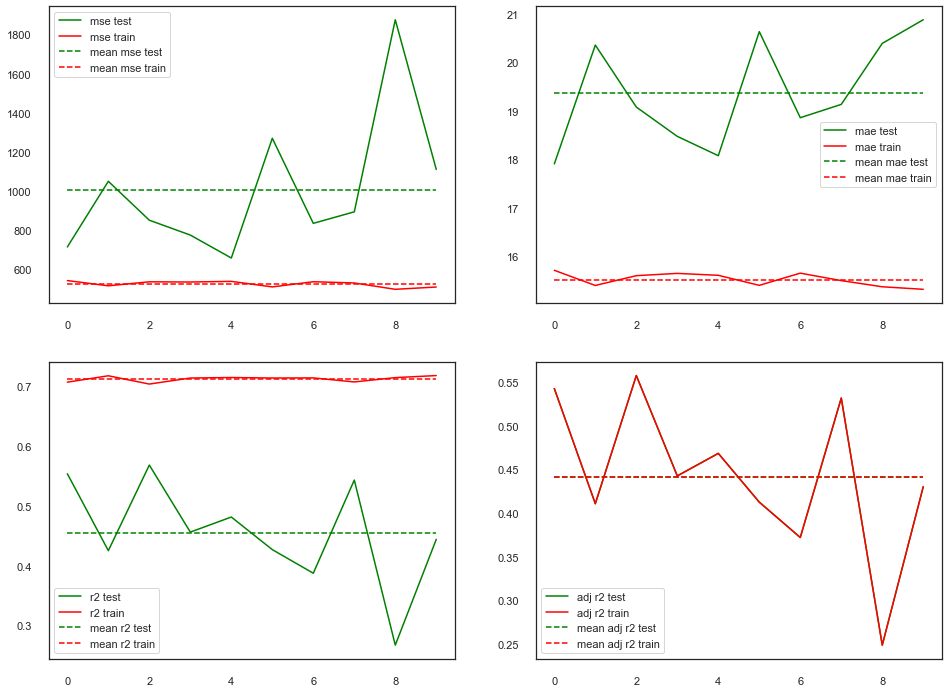

In [237]:
model = RandomForestRegressor(max_features=0.3, max_depth=10,n_estimators=800)
model.fit(X_train_cleaned, y_train)
score_model(model, X_test_cleaned, y_test, cross_valid=True)

In [ ]:
N = 30
mse = np.zeros(N)

tic=time.time()

for i in range(N):
    X_train, X_test, y_train1, y_test1 = train_test_split(X_train_cleaned_scaled, y_train, train_size=0.7, random_state=0)
    reg = RandomForestRegressor(n_estimators=(i+1)*10)
    reg.fit(X_train, y_train1)
    Z = reg.predict(X_test)
    mse [i] = mean_squared_error(y_test1, Z)

toc=time.time()

print("Temps de calcul = "+str(toc-tic)+"sec")

plt.plot([10*(i+1) for i in range(30)], mse, label="MSE")
plt.legend()
plt.show()
pgrid = {"max_depth": [1, 3, 5, 8, 10],
        "max_features": [0.1, 0.2, 0.3, 0.5],
        'n_estimators': [100, 150, 200, 250]
        }

In [ ]:
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)


grid_search.fit(X_train_cleaned, y_train)
best_score=grid_search.best_estimator_.score(X_test_cleaned, y_test)
best_max_features=grid_search.best_estimator_.max_features
best_max_depth=grid_search.best_estimator_.max_depth
best_n_estimators=grid_search.best_estimator_.n_estimators
print("best_score ", best_score)
print("best_max_features ", best_max_features)
print("best_max_depth ", best_max_depth)
print("best_n_estimators ", best_n_estimators)

#### Scaled dataset

#### New features dataset

In [ ]:
model = RandomForestRegressor(max_features=0.3, max_depth=10,n_estimators=800)
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = RandomForestRegressor()
model.fit(X_train_cleaned_pca, y_train)
score_model(model, X_test_cleaned_pca, y_test, cross_valid=True)

<a href="#top">back to top</a>

<a name="ET">

### Extra Trees

In [ ]:
rf = LinearRegression()
sfs1 = SFS(rf, 
           k_features=(1,X_train_cleaned.shape[1]), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train_cleaned, y_train)
sfs1.subsets_

In [ ]:
print(f"Features: {sfs1.k_feature_names_}",
      f"MSE: {-sfs1.k_score_:.2f}",
      sep="\n")

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned[list(sfs1.k_feature_names_)], y_train)
score_model(model, X_test_cleaned[list(sfs1.k_feature_names_)], y_test, cross_valid=True)

#### New features dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_pca, y_train_pca)
score_model(model, X_test_cleaned_pca, y_test_pca, cross_valid=True)

In [ ]:
model = ExtraTreesRegressor(max_features=0.3, max_depth=10,n_estimators=800)
model.fit(X_train_cleaned, y_train)
r2 = model.score(X_test_cleaned, y_test)

y_preds = model.predict(X_test_cleaned)
mse = mean_squared_error(y_test, y_preds)

print("ExtraTrees",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

#### Feature selection

#### GridSearch

In [ ]:
pgrid = {"max_depth": [1, 3, 5, 8, 10],
        "max_features": [0.1, 0.2, 0.3, 0.5],
        'n_estimators': [100, 150, 200, 250]
        }



grid_search = GridSearchCV(ExtraTreesRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)


grid_search.fit(X_train_cleaned, y_train)
best_score=grid_search.best_estimator_.score(X_test_cleaned, y_test)
best_max_features=grid_search.best_estimator_.max_features
best_max_depth=grid_search.best_estimator_.max_depth
best_n_estimators=grid_search.best_estimator_.n_estimators
print("best_score ", best_score)
print("best_max_features ", best_max_features)
print("best_max_depth ", best_max_depth)
print("best_n_estimators ", best_n_estimators)

#### Scaled dataset

#### New features dataset

#### PCA dataset

In [ ]:
model = RandomForestRegressor()
model.fit(X_train_cleaned_pca, y_train)
score_model(model, X_test_cleaned_pca, y_test, cross_valid=True)

<a href="#top">back to top</a>

<a name="XGB">

### XG Boost

In [ ]:
rf = LinearRegression()
sfs1 = SFS(rf, 
           k_features=(1,X_train_cleaned.shape[1]), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train_cleaned, y_train)
sfs1.subsets_

In [ ]:
print(f"Features: {sfs1.k_feature_names_}",
      f"MSE: {-sfs1.k_score_:.2f}",
      sep="\n")

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned[list(sfs1.k_feature_names_)], y_train)
score_model(model, X_test_cleaned[list(sfs1.k_feature_names_)], y_test, cross_valid=True)

#### New features dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_pca, y_train_pca)
score_model(model, X_test_cleaned_pca, y_test_pca, cross_valid=True)

In [ ]:
xgb_model = XGBRegressor(objective="reg:linear", learning_rate=0.05, max_depth=3, nb_estimators=600)

xgb_model.fit(X_train_encoded, y_train)
r2 = xgb_model.score(X_test_cleaned, y_test)
y_pred = xgb_model.predict(X_test_encoded)

mse=mean_squared_error(y_test, y_pred)

print("XGBoost",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

In [ ]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.01, .03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_encoded,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

<a href="#top">back to top</a>

<a name="Catboost">

### Catboost

In [ ]:
rf = LinearRegression()
sfs1 = SFS(rf, 
           k_features=(1,X_train_cleaned.shape[1]), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train_cleaned, y_train)
sfs1.subsets_

In [ ]:
print(f"Features: {sfs1.k_feature_names_}",
      f"MSE: {-sfs1.k_score_:.2f}",
      sep="\n")

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned[list(sfs1.k_feature_names_)], y_train)
score_model(model, X_test_cleaned[list(sfs1.k_feature_names_)], y_test, cross_valid=True)

#### New features dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_feature_eng, y_train)
score_model(model, X_test_cleaned_feature_eng, y_test, cross_valid=True)

#### PCA dataset

In [ ]:
model = LinearRegression()
model.fit(X_train_cleaned_pca, y_train_pca)
score_model(model, X_test_cleaned_pca, y_test_pca, cross_valid=True)

In [ ]:
cb_model = CatBoostRegressor(iterations=10,
                          learning_rate=0.5,
                          depth=4)

cb_model.fit(X_train_encoded, y_train)
r2 = cb_model.score(X_test_cleaned, y_test)
y_pred = cb_model.predict(X_test_encoded)

mse=mean_squared_error(y_test, y_pred)

print("Catboost",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

In [ ]:
cb1 = CatBoostRegressor()
parameters = {'learning_rate': [0.01, .03, 0.05, .07, 0.1, 0.2, 0.5],
              'iterations': [5, 10, 20],
              'depth' : [4, 5, 6]}

cb_grid = GridSearchCV(cb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

cb_grid.fit(X_train_encoded,
         y_train)

print(cb_grid.best_score_)
print(cb_grid.best_params_)

<a href="#top">back to top</a>

<a name="best_model">

## Best model
---

<a href="#top">back to top</a>